In [ ]:

%matplotlib inline

import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import gc

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, average_precision_score
from sklearn.metrics import precision_recall_curve, auc

from sklearn.preprocessing import StandardScaler, LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/bs140513_032310.csv')
print(df.shape)
df.head()

(594643, 10)


,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


## Check for missing values

In [ ]:
df.isna().any()

,0
step,False
customer,False
age,False
gender,False
zipcodeOri,False
merchant,False
zipMerchant,False
category,False
amount,False
fraud,False


In [ ]:
column_change = [c for c in df.columns if c not in ['step', 'amount', 'fraud']]
column_change

['customer',
 'age',
 'gender',
 'zipcodeOri',
 'merchant',
 'zipMerchant',
 'category']

In [ ]:
df[column_change] = df[column_change].replace("'", "", regex=True)

In [ ]:
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0


# Exploratory Data Analysis


In [ ]:
df.nunique()

,0
step,180
customer,4112
age,8
gender,4
zipcodeOri,1
merchant,50
zipMerchant,1
category,15
amount,23767
fraud,2


Note: Since ZipMerchant and ZipcodeOri only contain one distinct value, these columns can be removed.

In [ ]:
df = df.drop(['zipcodeOri','zipMerchant'], axis = 1)
df.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,C1093826151,4,M,M348934600,es_transportation,4.55,0
1,0,C352968107,2,M,M348934600,es_transportation,39.68,0
2,0,C2054744914,4,F,M1823072687,es_transportation,26.89,0
3,0,C1760612790,3,M,M348934600,es_transportation,17.25,0
4,0,C757503768,5,M,M348934600,es_transportation,35.72,0


In [ ]:
# Create two dataframes with fraud and non-fraud data
df_fraud = df.loc[df.fraud == 1]
df_non_fraud = df.loc[df.fraud == 0]

In [ ]:
df_fraud.head()

,step,customer,age,gender,merchant,category,amount,fraud
88,0,C583110837,3,M,M480139044,es_health,44.26,1
89,0,C1332295774,3,M,M480139044,es_health,324.50,1
434,0,C1160421902,3,M,M857378720,es_hotelservices,176.32,1
435,0,C966214713,3,M,M857378720,es_hotelservices,337.41,1
553,0,C1450140987,4,F,M1198415165,es_wellnessandbeauty,220.11,1


In [ ]:
df_non_fraud.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,C1093826151,4,M,M348934600,es_transportation,4.55,0
1,0,C352968107,2,M,M348934600,es_transportation,39.68,0
2,0,C2054744914,4,F,M1823072687,es_transportation,26.89,0
3,0,C1760612790,3,M,M348934600,es_transportation,17.25,0
4,0,C757503768,5,M,M348934600,es_transportation,35.72,0


In [ ]:
def edaplot(data: pd.DataFrame, col: str, title: str = None, hue: str = None, legend: bool = True):
    plt.figure(figsize=(17, 14))
    plt.title(title)
    ax = sns.countplot(
        data=data,
        x=col,
        palette='tab10',
        order=data[col].value_counts().index,
        hue=hue if hue else None
    )

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
                f"{round(100 * height / len(data[col]), 2)}%",
                ha='center', va='bottom')

    if data[col].nunique() > 5:
        plt.xticks(rotation=45)

    if legend:
        ax.legend(title=hue)

    plt.show()


<ipython-input-13-6ab33f0bc61b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
<ipython-input-13-6ab33f0bc61b>:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=hue)


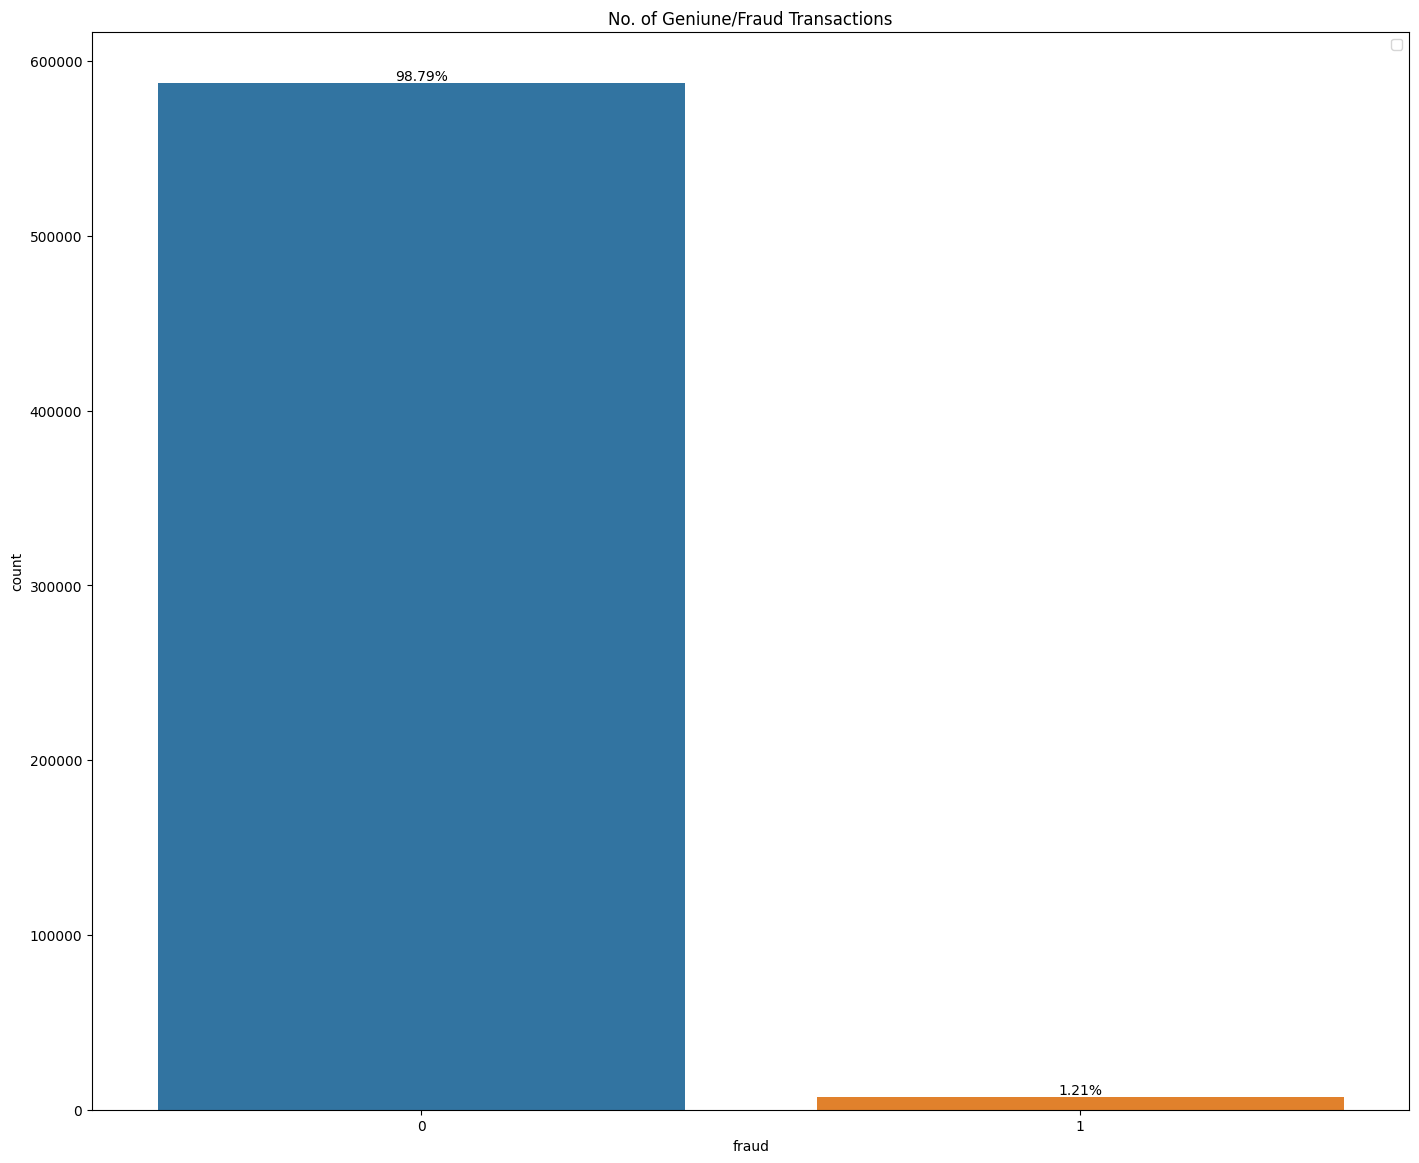

In [ ]:
edaplot(df, 'fraud', title = 'No. of Geniune/Fraud Transactions', legend=True)

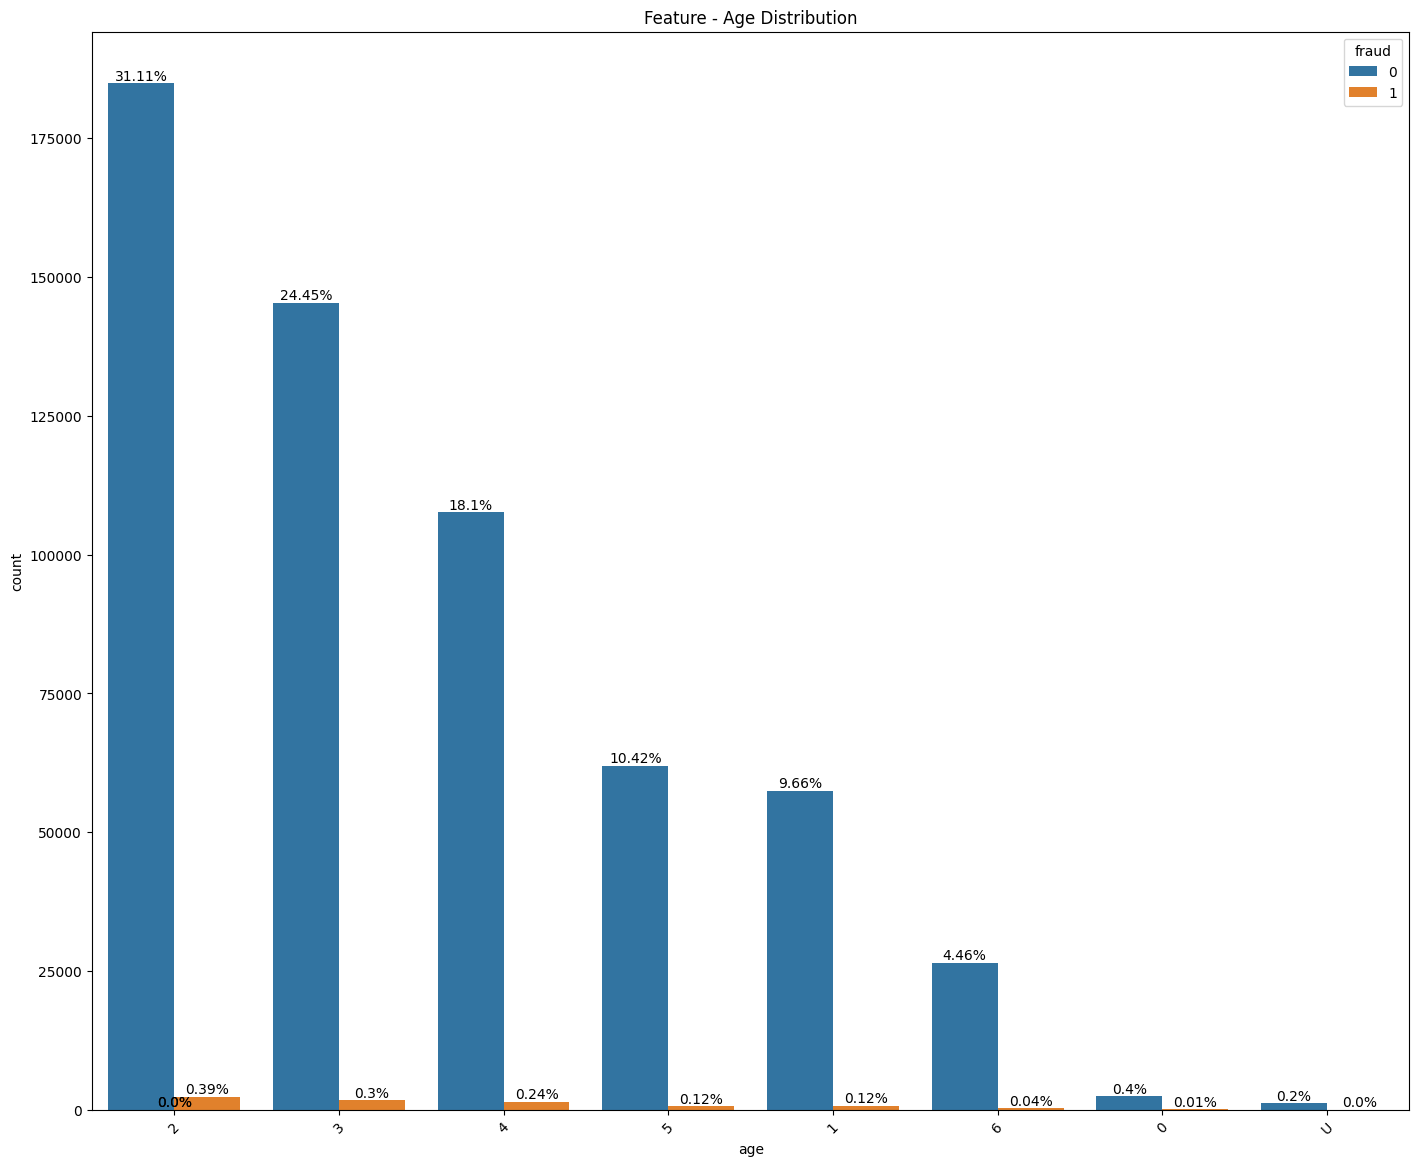

In [ ]:
edaplot(df, 'age', title = 'Feature - Age Distribution', hue = 'fraud')

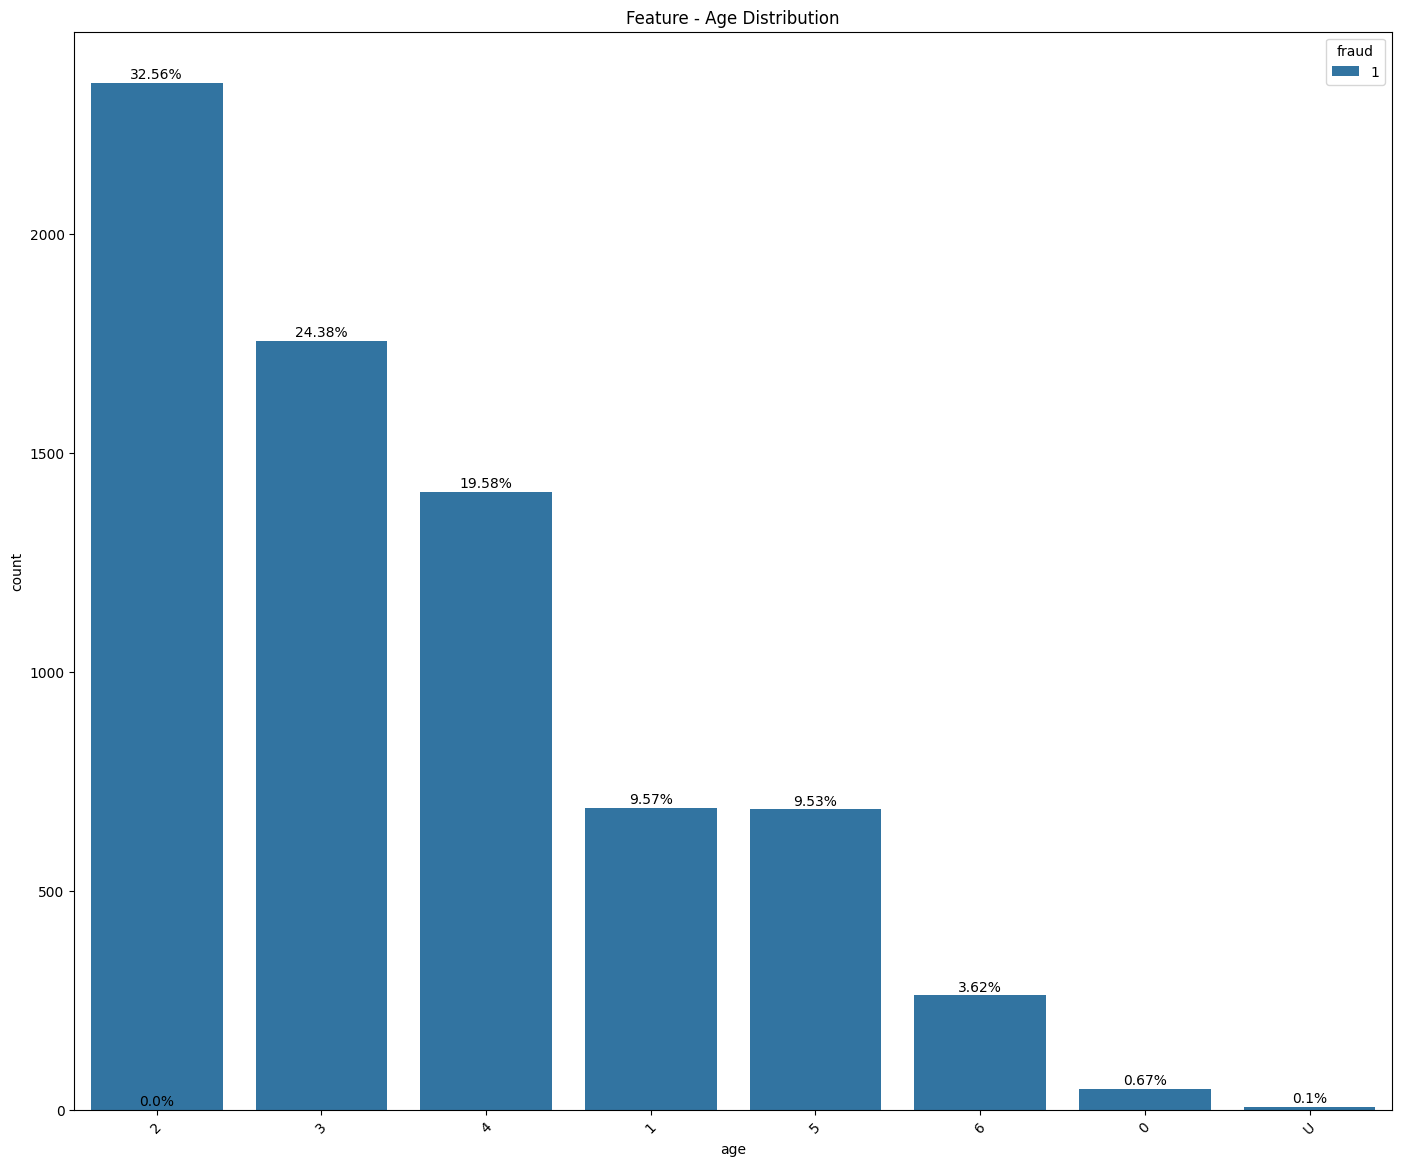

In [ ]:
edaplot(df_fraud, 'age', title = 'Feature - Age Distribution', hue = 'fraud')

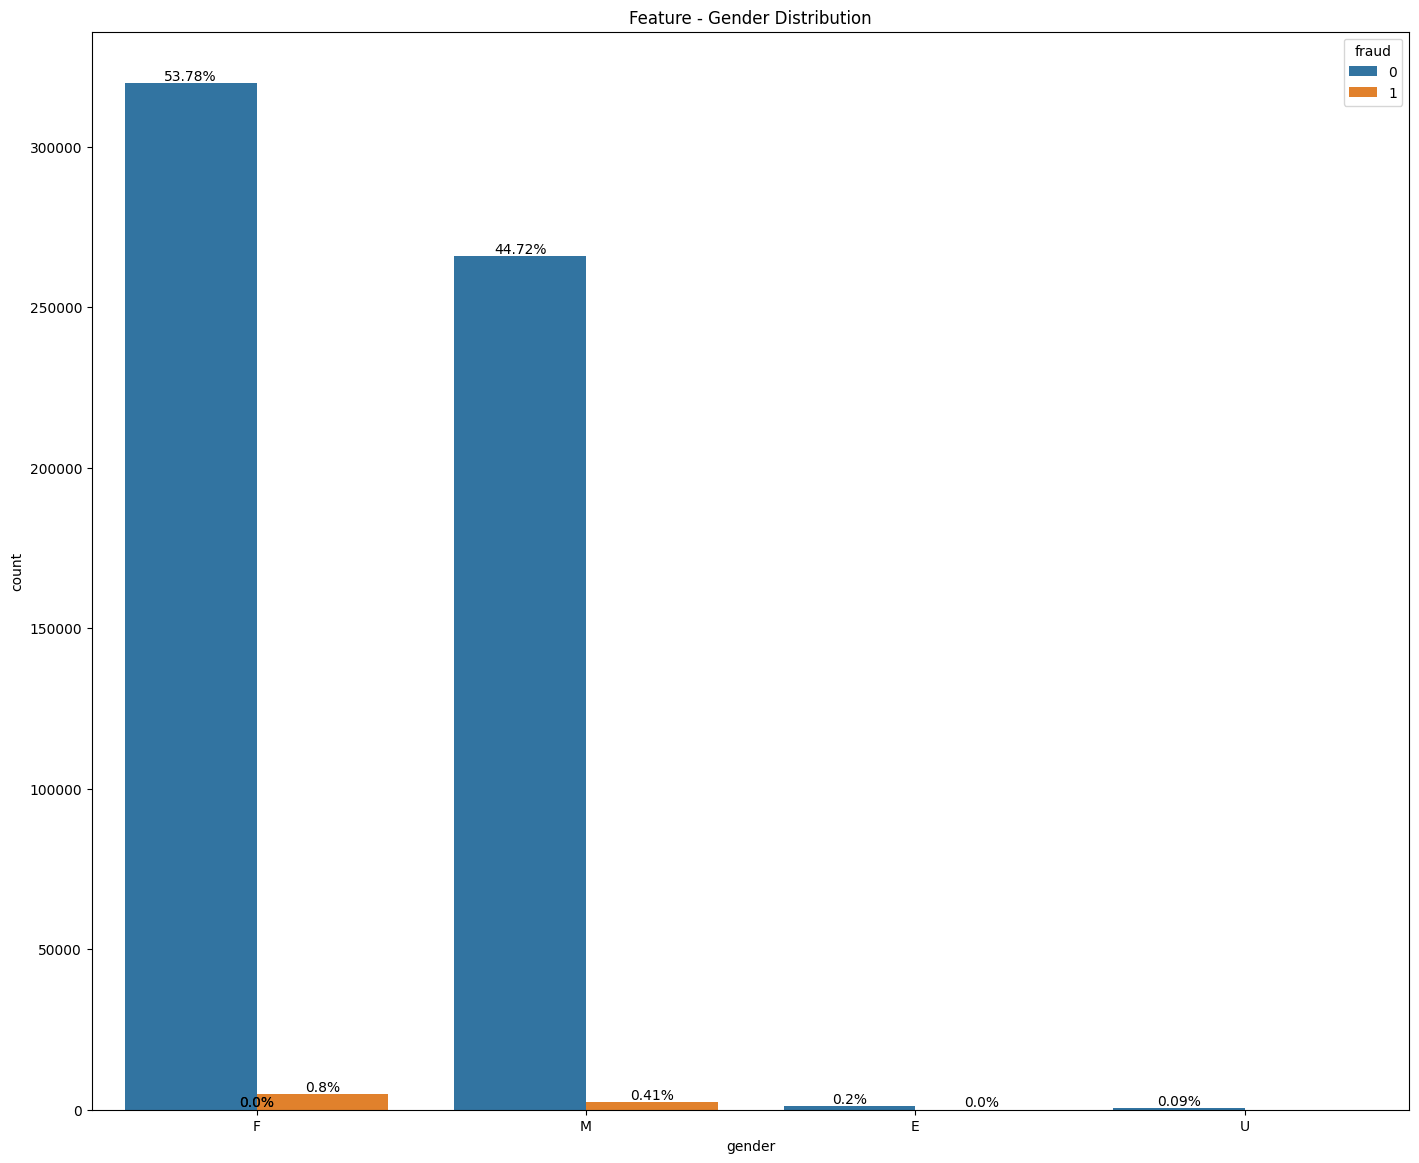

In [ ]:
edaplot(df, 'gender', title = 'Feature - Gender Distribution', hue = 'fraud')

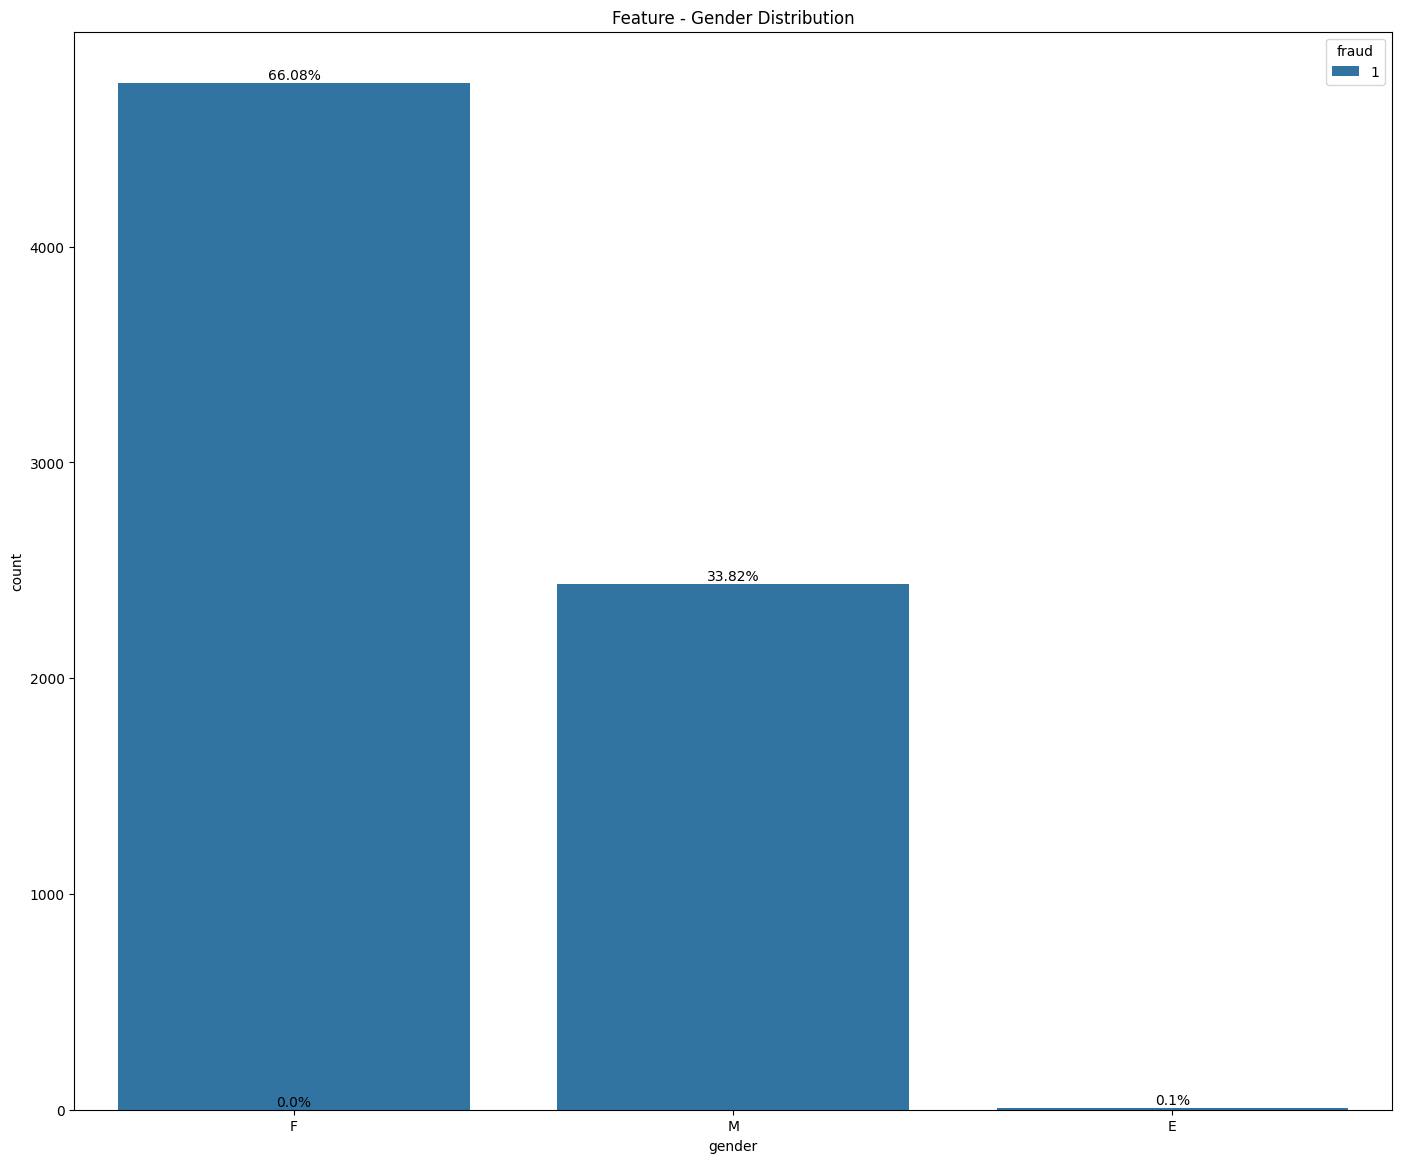

In [ ]:
edaplot(df_fraud, 'gender', title = 'Feature - Gender Distribution', hue = 'fraud')

In [ ]:
print(df['category'].unique())

['es_transportation' 'es_health' 'es_otherservices' 'es_food'
 'es_hotelservices' 'es_barsandrestaurants' 'es_tech' 'es_sportsandtoys'
 'es_wellnessandbeauty' 'es_hyper' 'es_fashion' 'es_home' 'es_contents'
 'es_travel' 'es_leisure']


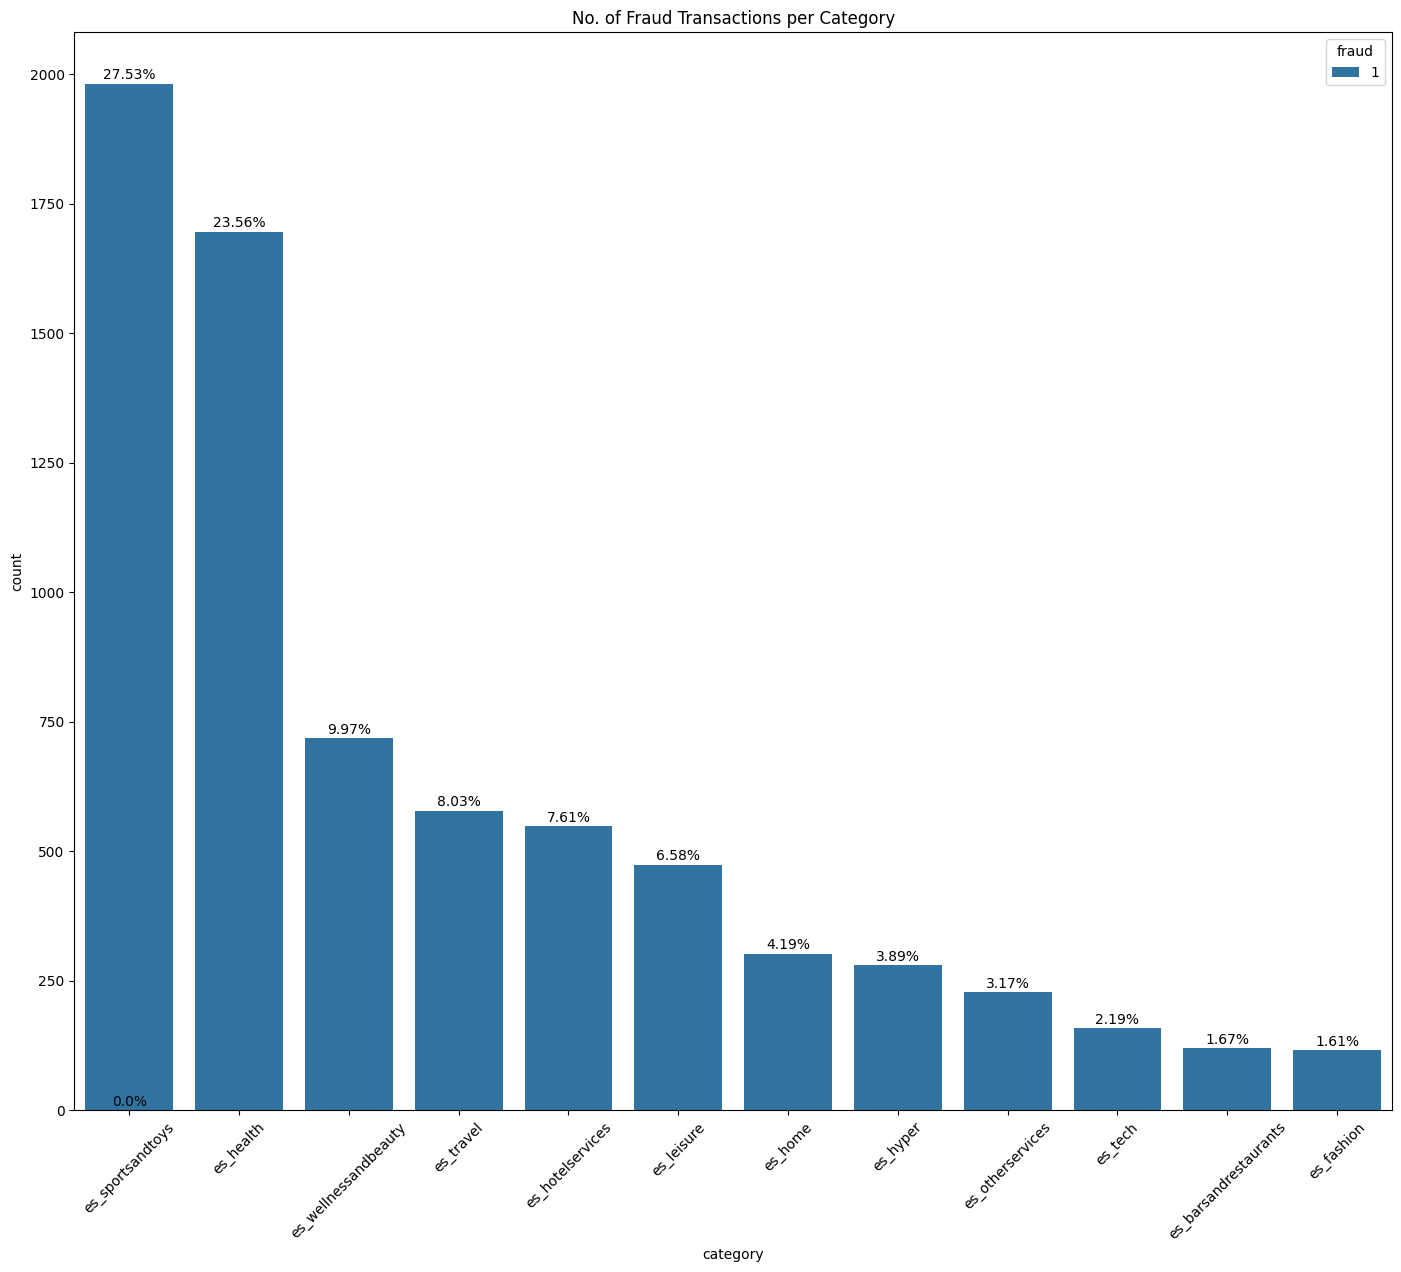

In [ ]:
edaplot(df_fraud, 'category', title = 'No. of Fraud Transactions per Category', hue = 'fraud', legend=True)

es_sportsandtoys and es_health account for more than 40% of all fraudulent transactions.

In [ ]:
df.groupby('category')['fraud'].mean()

,fraud
category,
es_barsandrestaurants,0.018829
es_contents,0.000000
es_fashion,0.017973
es_food,0.000000
es_health,0.105126
es_home,0.152064
es_hotelservices,0.314220
es_hyper,0.045917
es_leisure,0.949900


<ipython-input-13-6ab33f0bc61b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
<ipython-input-13-6ab33f0bc61b>:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=hue)


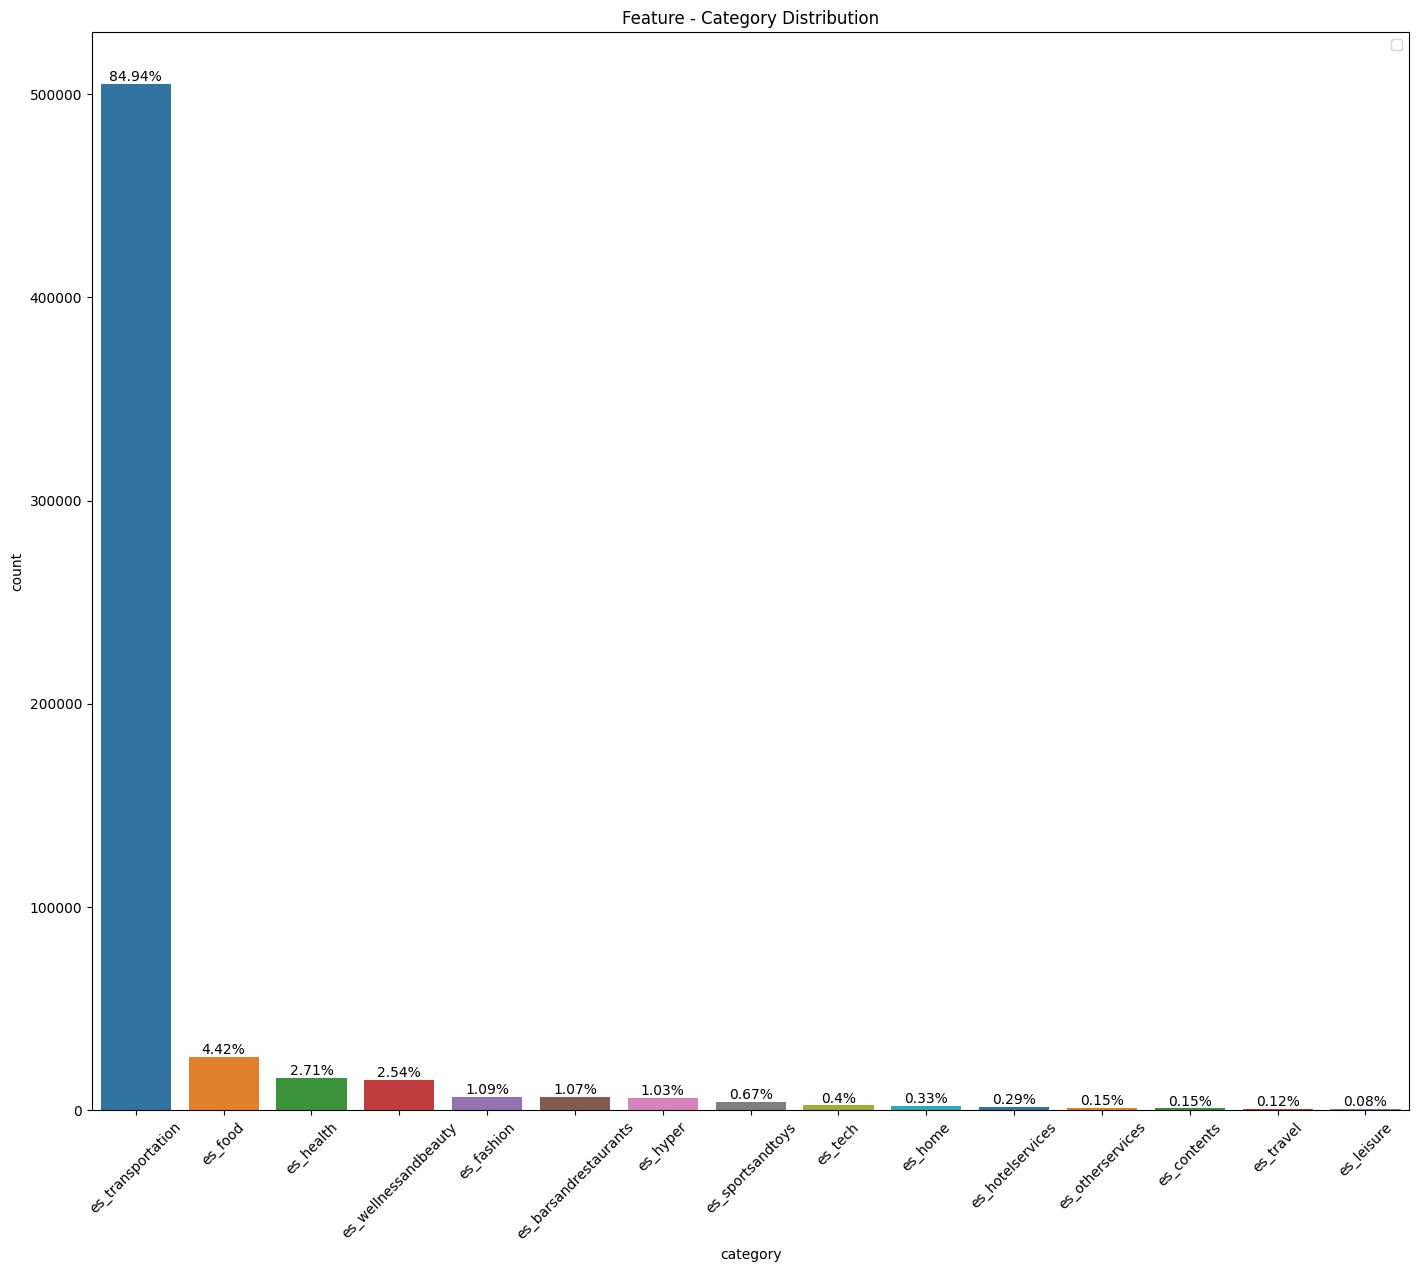

In [ ]:
edaplot(df, 'category', title = 'Feature - Category Distribution')

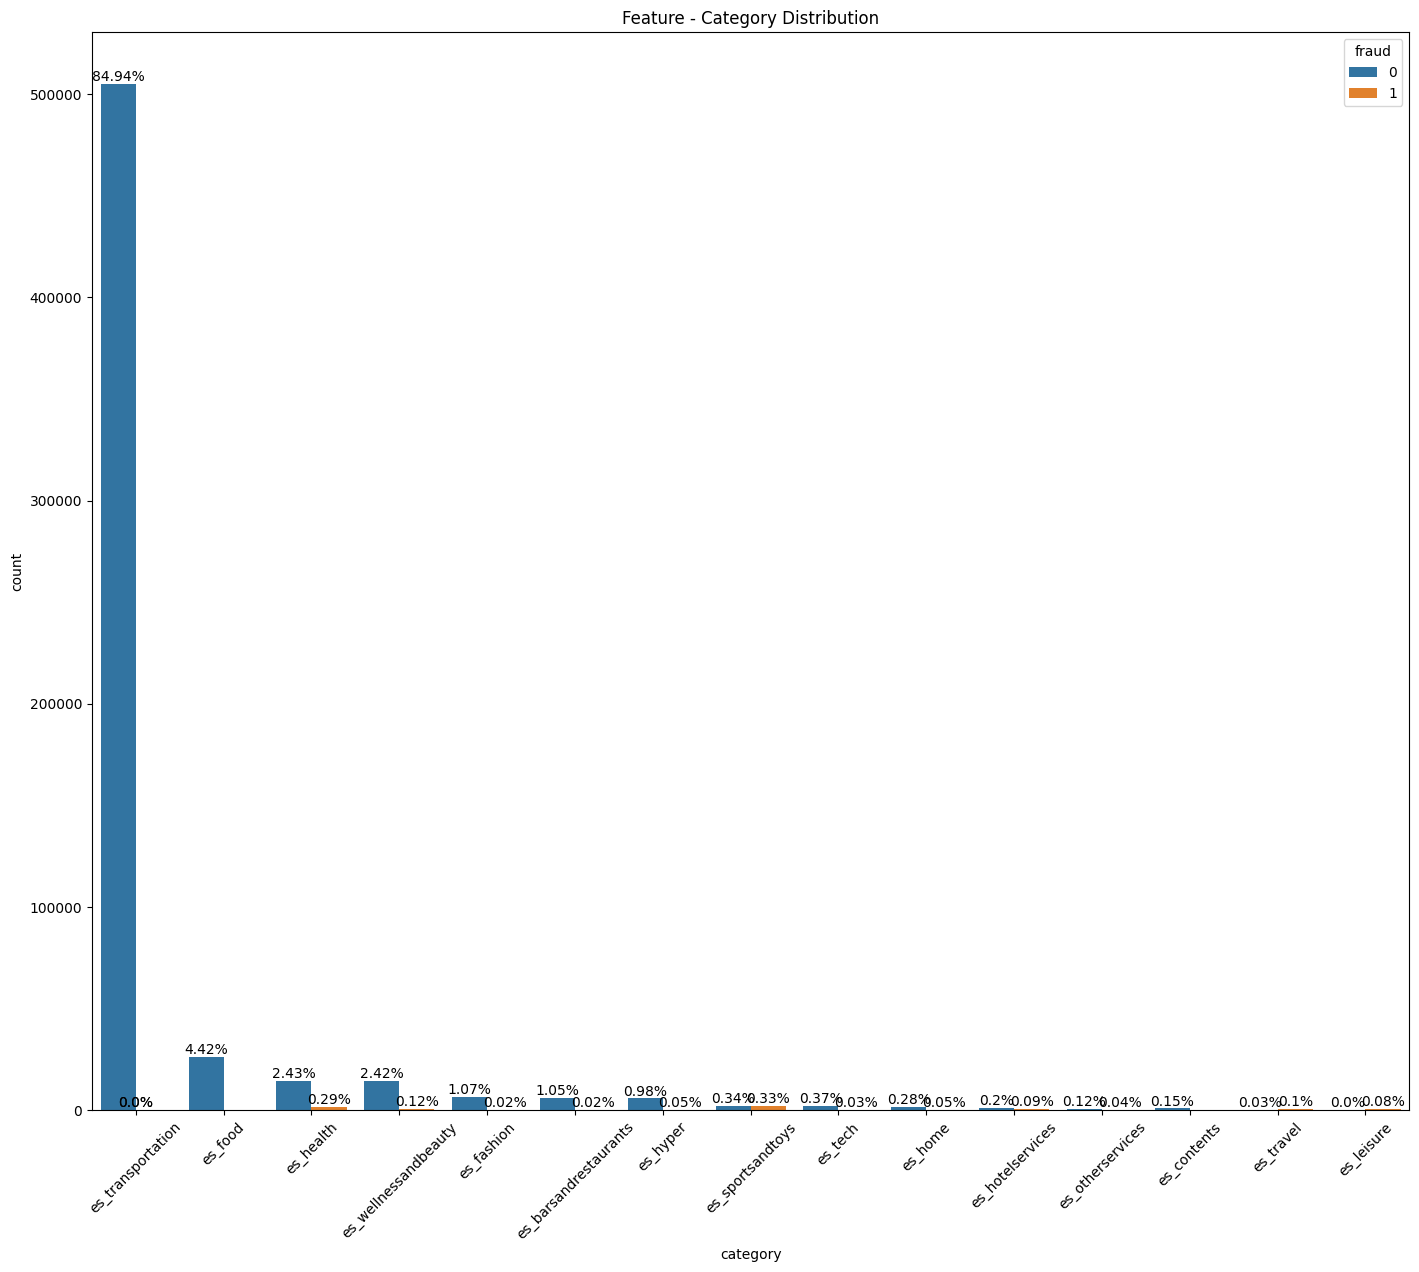

In [ ]:
edaplot(df, 'category', title = 'Feature - Category Distribution', hue = 'fraud')

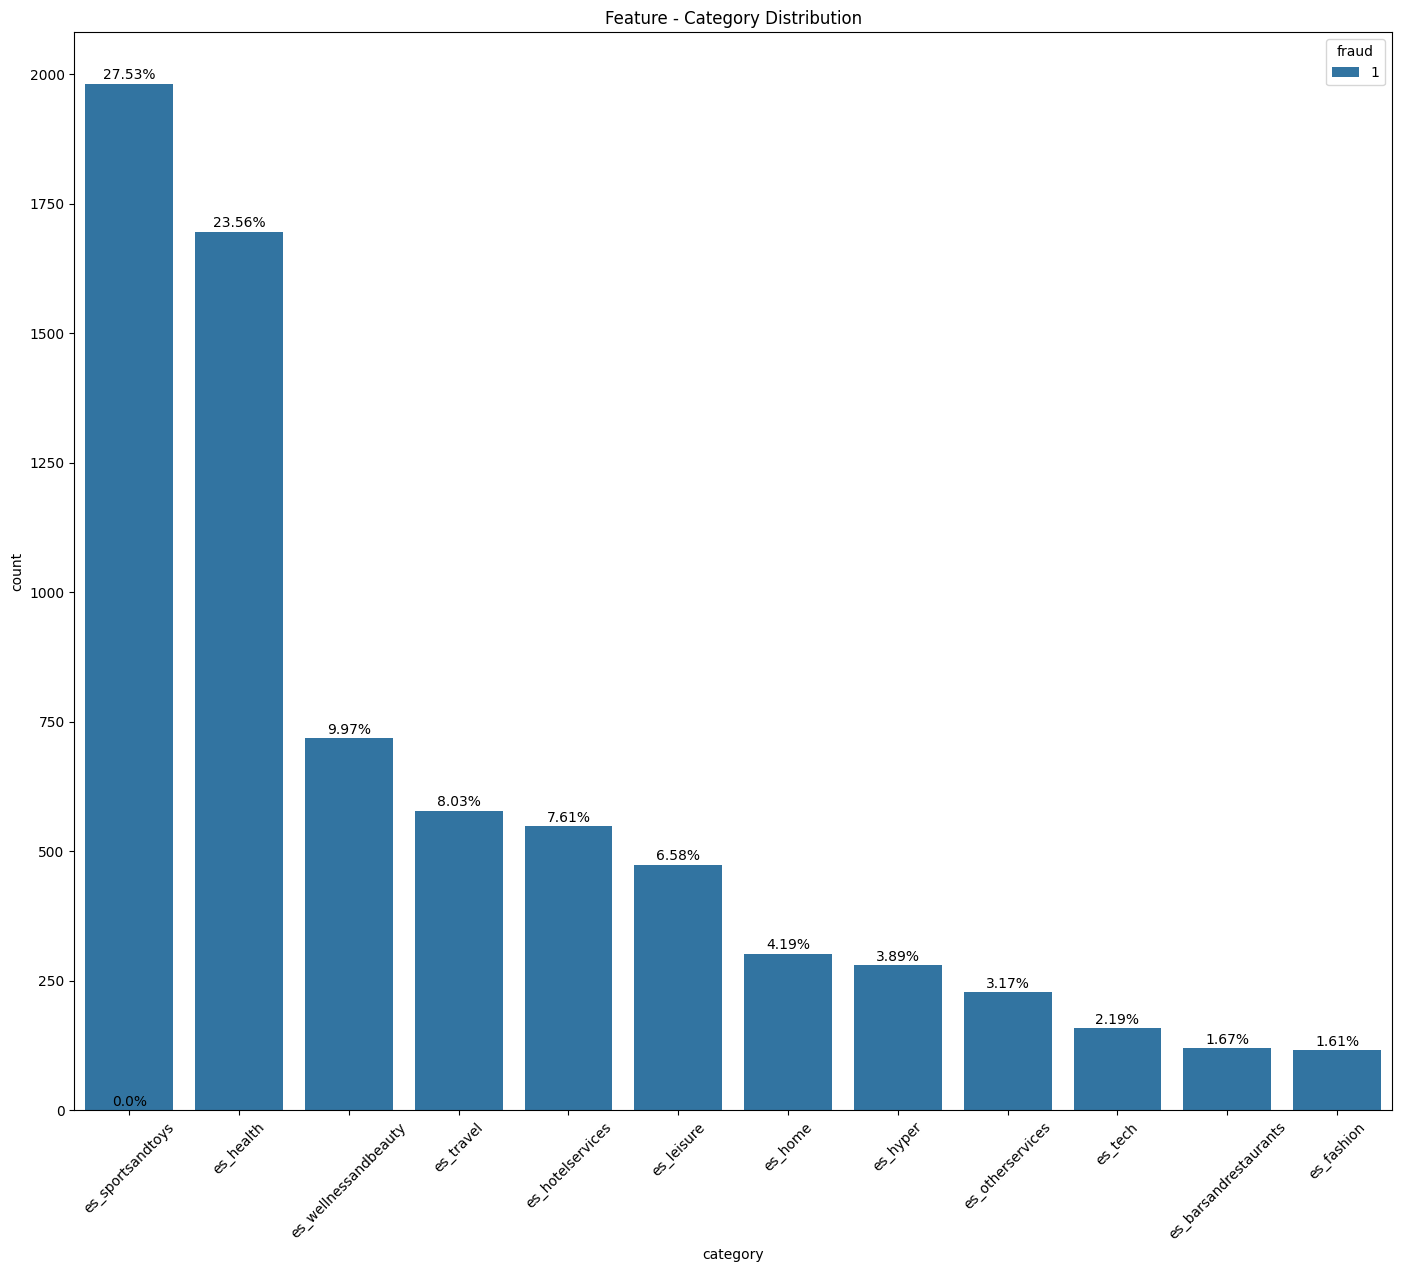

In [ ]:
edaplot(df_fraud, 'category', title = 'Feature - Category Distribution', hue = 'fraud')

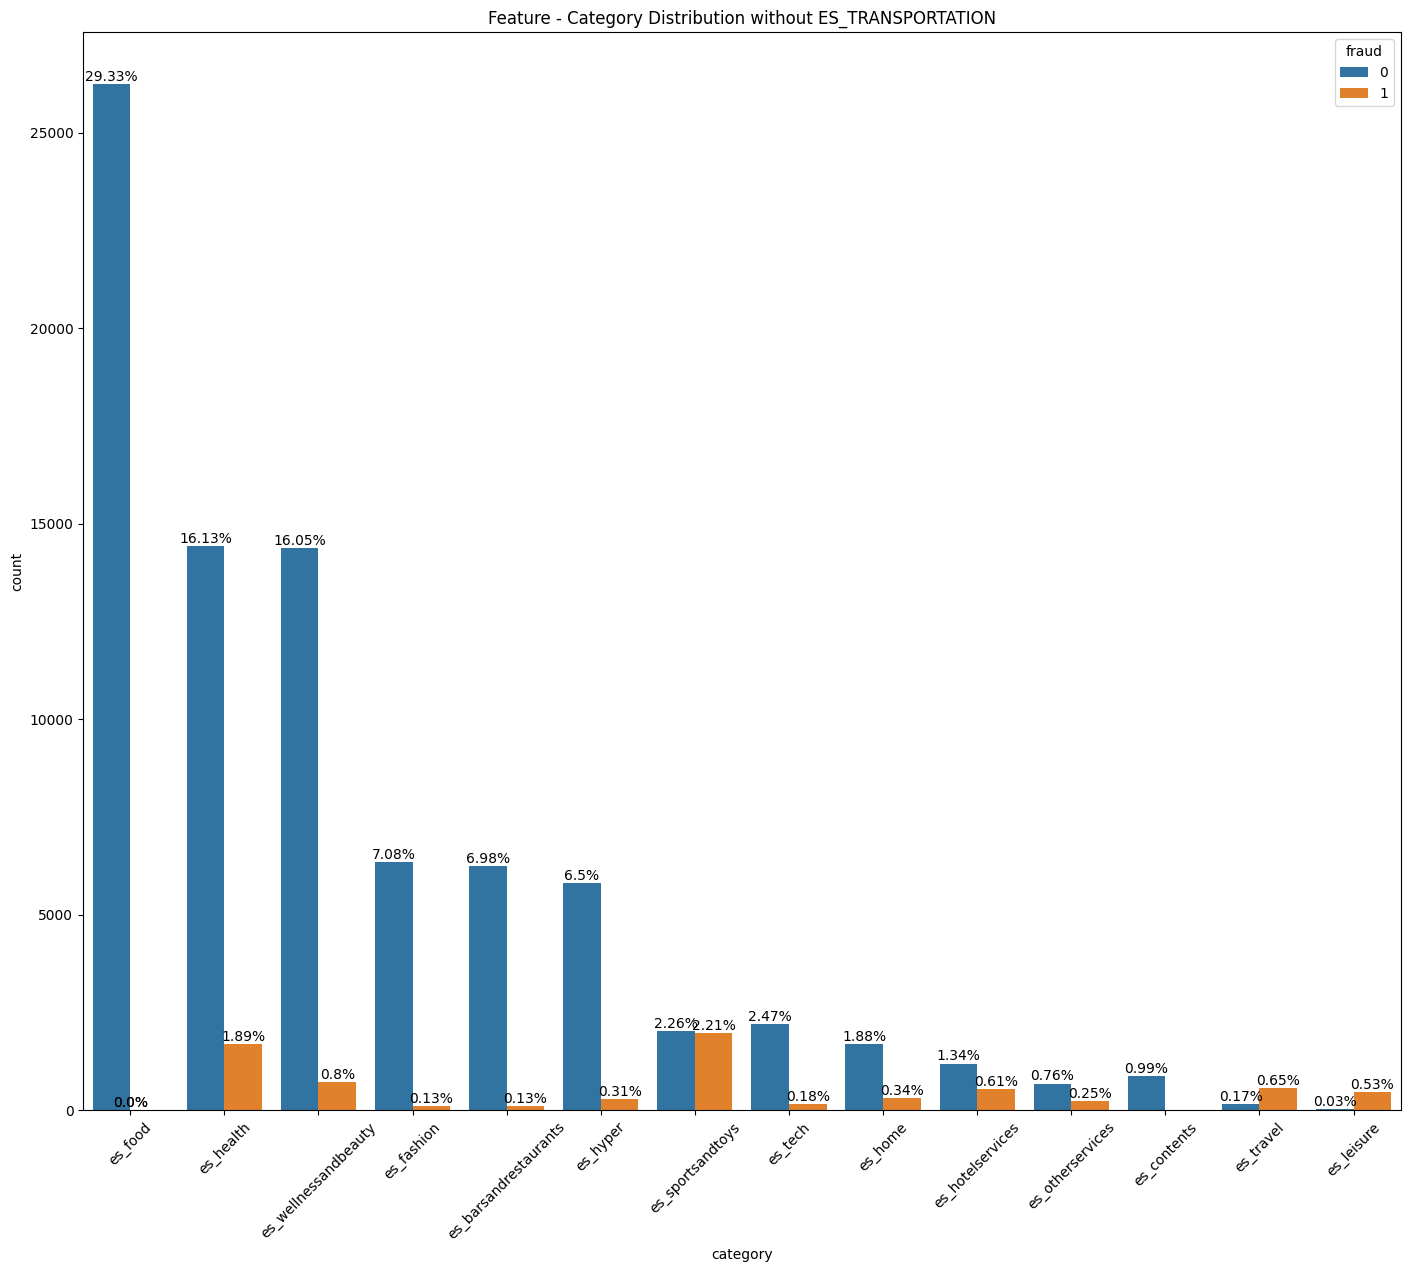

In [ ]:
temp = df[df['category'] != 'es_transportation']
edaplot(temp, 'category', title = 'Feature - Category Distribution without ES_TRANSPORTATION', hue = 'fraud')

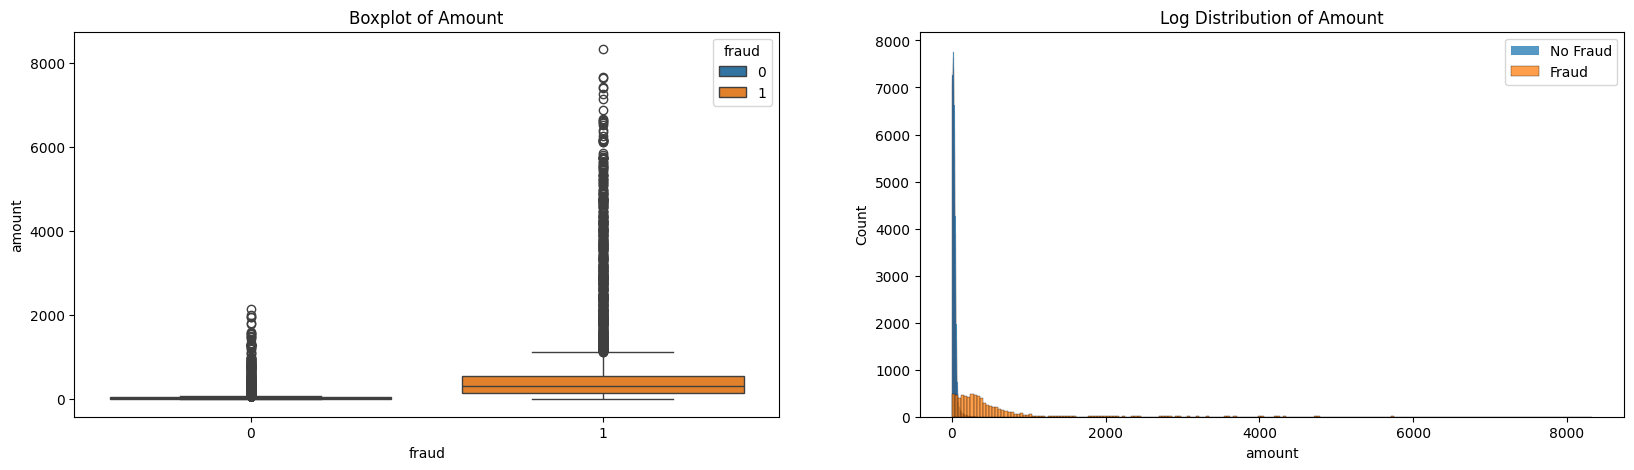

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 5))
ax1.set_title('Boxplot of Amount')
sns.boxplot(data = df, x = 'fraud', y = 'amount', hue = 'fraud', ax = ax1)

ax2.set_title('Log Distribution of Amount')
sns.histplot(df[df['fraud'] == 0]['amount'], label = 'No Fraud', ax = ax2)
sns.histplot(df[df['fraud'] == 1]['amount'], label = 'Fraud', ax = ax2)
ax2.legend()
plt.show()

In [ ]:
print('Fraudulent Transaction:')
print(f"Maximun amount of transaction: {df[df['fraud'] == 1]['amount'].max()}")
print(f"Minimum amount of transaction: {df[df['fraud'] == 1]['amount'].min()}")
print(f"Amount amount of transaction: {df[df['fraud'] == 1]['amount'].mean()}")

print('\nNon-Fraudulent Transaction:')
print(f"Maximun amount of transaction: {df[df['fraud'] == 0]['amount'].max()}")
print(f"Minimum amount of transaction: {df[df['fraud'] == 0]['amount'].min()}")
print(f"Amount amount of transaction: {df[df['fraud'] == 0]['amount'].mean()}")

Fraudulent Transaction:
Maximun amount of transaction: 8329.96
Minimum amount of transaction: 0.03
Amount amount of transaction: 530.9265513888889

Non-Fraudulent Transaction:
Maximun amount of transaction: 2144.86
Minimum amount of transaction: 0.0
Amount amount of transaction: 31.847230386607713


# Data Preprocessing

In [ ]:
new_df = df.copy()
#Frequency Encoding customer and merchant features
for col in ['customer', 'merchant']:
    print(f"Frequency Encoding: {col} - {df[col].nunique()}")
    freq = df[col].value_counts()
    df[col] = df[col].apply(lambda x: freq[x])

Frequency Encoding: customer - 4112
Frequency Encoding: merchant - 50


In [ ]:
#Label Encoding age, gender, category
for col in ['gender', 'age', 'category']:
    print(f"Label Encoding: {col} - {df[col].nunique()}")
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

Label Encoding: gender - 4
Label Encoding: age - 8
Label Encoding: category - 15


In [ ]:
df.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,167,4,2,205426,12,4.55,0
1,0,169,2,2,205426,12,39.68,0
2,0,65,4,1,299693,12,26.89,0
3,0,171,3,2,205426,12,17.25,0
4,0,145,5,2,205426,12,35.72,0


### Importing relevant libraries & checking for correlation

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

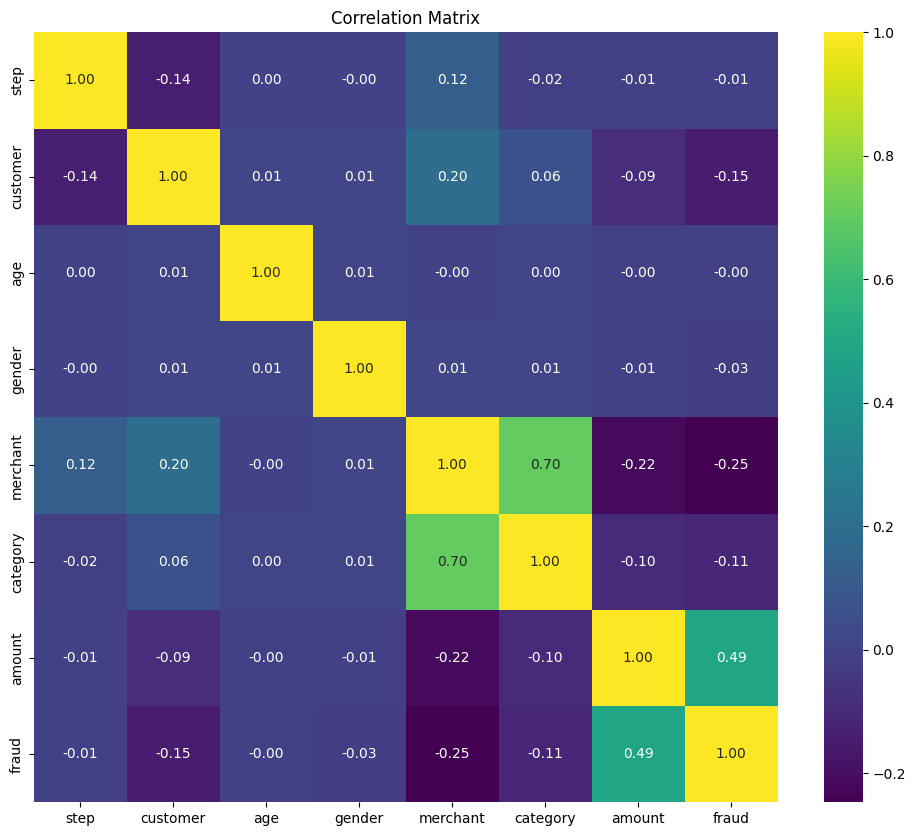

In [ ]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='viridis')
plt.title('Correlation Matrix')
plt.show()

It should be noted that characteristics, merchant, and category have minimal to no association. However, since we did feature engineering on them, we are unable to focus on that.

### Assiging dependent and independent variable

In [ ]:
X = df.drop(['fraud'], axis = 1)
y = df['fraud']
print(X.head())
print("\n\n", y.head())

   step  customer  age  gender  merchant  category  amount
0     0       167    4       2    205426        12    4.55
1     0       169    2       2    205426        12   39.68
2     0        65    4       1    299693        12   26.89
3     0       171    3       2    205426        12   17.25
4     0       145    5       2    205426        12   35.72


 0    0
1    0
2    0
3    0
4    0
Name: fraud, dtype: int64


# Dimensionality Reduction using PCA

### PCA


In [ ]:
scaler_pca = StandardScaler()
scaled_pca_df = scaler_pca.fit_transform(df)

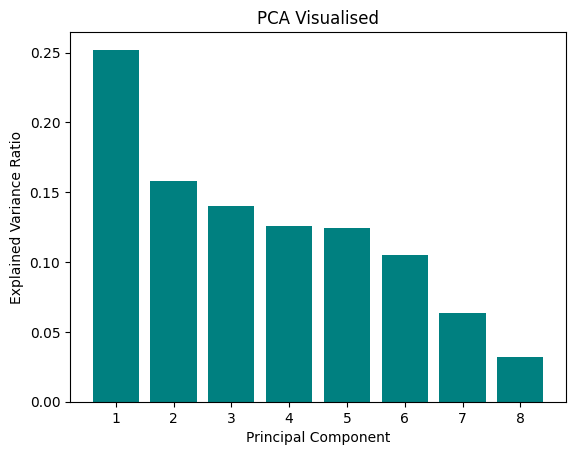

In [ ]:
pca = PCA(n_components = 8) # Creating a PCA model using total variables (explanatory or not).
pca.fit(scaled_pca_df) # Fit the data...

# Let's plot the explained_variance_ratio_ in a similar manner to the lecture slides...
plt.bar(range(1,9), pca.explained_variance_ratio_, color='teal') # Plot on the line graphs...
plt.title("PCA Visualised") # Show the title
plt.xlabel('Principal Component') # Show the x axis label
plt.ylabel('Explained Variance Ratio') # Show the y axis label
plt.xticks([1, 2, 3, 4, 5,6,7,8]) # Set the x axis range and values
plt.show() # Show the graph.

In [ ]:
print(pca.explained_variance_ratio_) # Inspect the properties of explained_variance_ratio_

[0.25208542 0.15778136 0.13992907 0.12550146 0.12431942 0.10475934
 0.06324677 0.03237718]


All of the features are significant to the dataset, according to the results of Principal Component analysis.

# Addressing Imbalance Data

### Checking if the dataset is imbalanced

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

y_copy = y.copy()
# Computing class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

# Creating a dictionary to map class labels to their computed weights
class_weight_dict = dict(zip(np.unique(y), class_weights))

class_weight_dict

{np.int64(0): np.float64(0.5061282541455085),
 np.int64(1): np.float64(41.29465277777778)}

The given dataset can be characterized as unbalanced, as can be seen above.
In their publication, Haibo He and Garcia (2009) suggest a sophisticated approach to problem solving that makes use of the synthetic minority oversampling technique.

## Splitting the Dataset into Tes_train_Split

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

We apply the train-test split before using SMOTE to avoid training a model that performs well only on the artificially balanced data but poorly in real-world scenarios where class imbalance remains. If oversampling is done before splitting, information from the synthetic data could leak into the test set, leading to misleading results. The goal of SMOTE is to help the model better learn patterns in the minority class, but its effectiveness should be evaluated on a test set that reflects the original class distribution.

We used SMOTE (Synthetic Minority Oversampling Technique) [2] to balance the dataset, resulting in an equal number of instances for both classes (0 and 1).

Class imbalance is a common issue in fraud detection datasets (ProjectPro, 2023). To address this, SMOTE helps by generating synthetic samples of the minority class, particularly improving performance in non-ensemble classification models such as Logistic Regression and KNN.

To compare model performance with and without SMOTE, Random Forest and XGBoost models are trained on the original imbalanced dataset without applying SMOTE.

## Classifiers

### Builing a funtion to early evaluate the classifier models

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Classification report
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve and AUC
    try:
        y_scores = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='darkgray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.show()
    except AttributeError:
        print(f"{model_name} does not support predict_proba, ROC curve cannot be plotted.")

    # Precision-Recall Curve and AUC
    try:
        precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)
        pr_auc = auc(recall, precision)

        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='green', label=f'PR Curve (area = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve for {model_name}')
        plt.legend(loc='best')
        plt.show()
    except AttributeError:
        print(f"{model_name} does not support predict_proba, PR curve cannot be plotted.")


Evaluating these models can be challenging. Although the ROC curve was initially considered for assessment, Haibo He and Garcia (2009) highlighted its limitations and recommended using Precision-Recall curves as a more effective alternative for imbalanced datasets.

#### SMOTE Classifiers

#### Initializing SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
X_train_sm, y_train_sm = smote.fit_resample(X_train,y_train)

### Non-SMOTE Classifiers

Although SMOTE was applied to Random Forest and XGBoost, the resulting models performed significantly worse compared to those trained without SMOTE. Haibo He and Garcia (2009) also discussed a variant called SMOTEBoost, which integrates SMOTE with the ensemble method AdaBoost. Building on this, we further explore the use of other ensemble algorithms.

#### Random Forest

Classification Report for Random Forest Classifier:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    193918
           1       0.91      0.80      0.85      2315

    accuracy                           1.00    196233
   macro avg       0.95      0.90      0.92    196233
weighted avg       1.00      1.00      1.00    196233



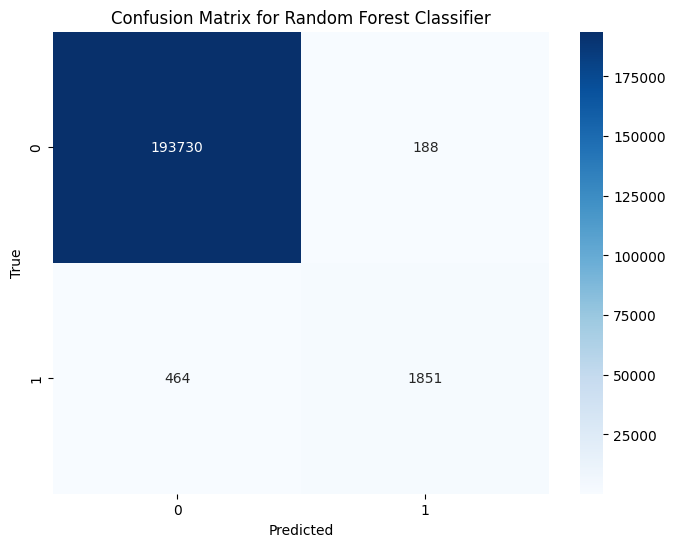

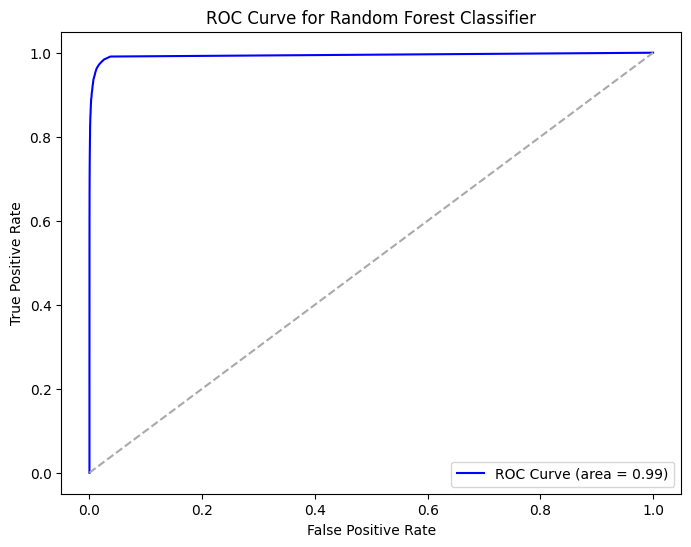

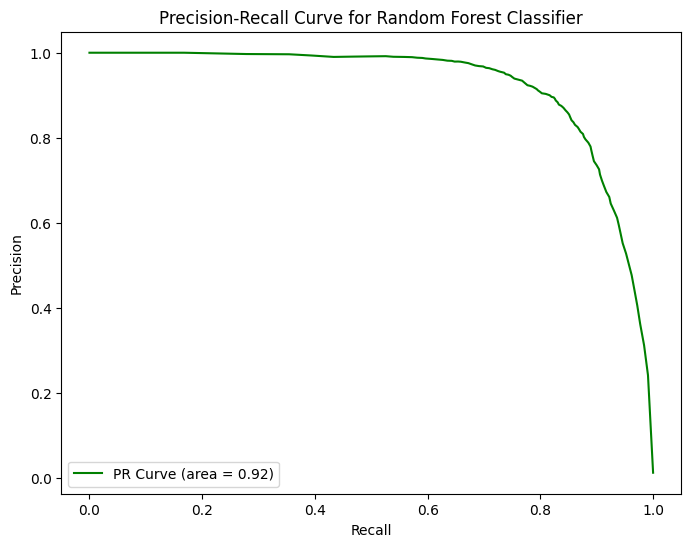

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate the RandomForestClassifier model
random_forest_model = RandomForestClassifier()

# Evaluate the model
evaluate_model(random_forest_model, "Random Forest Classifier", X_train, y_train, X_test, y_test)

#### Balanced Random Forest

In [ ]:
import warnings
# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

Classification Report for Balanced Random Forest Classifier:

              precision    recall  f1-score   support

           0       1.00      0.97      0.99    193918
           1       0.29      0.99      0.45      2315

    accuracy                           0.97    196233
   macro avg       0.65      0.98      0.72    196233
weighted avg       0.99      0.97      0.98    196233



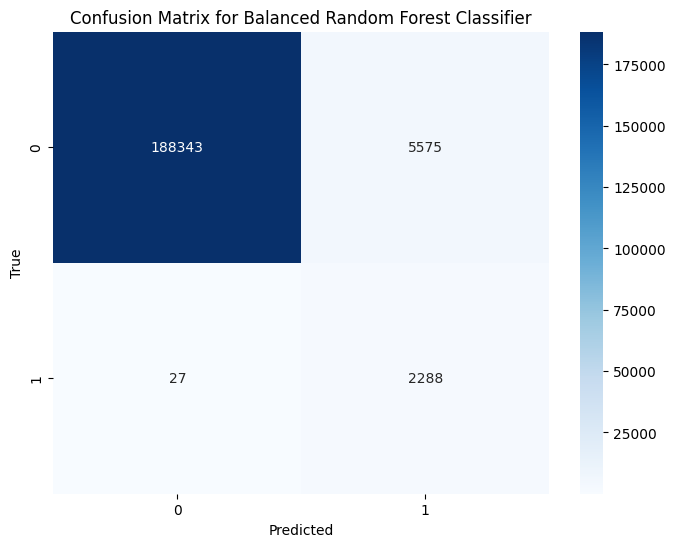

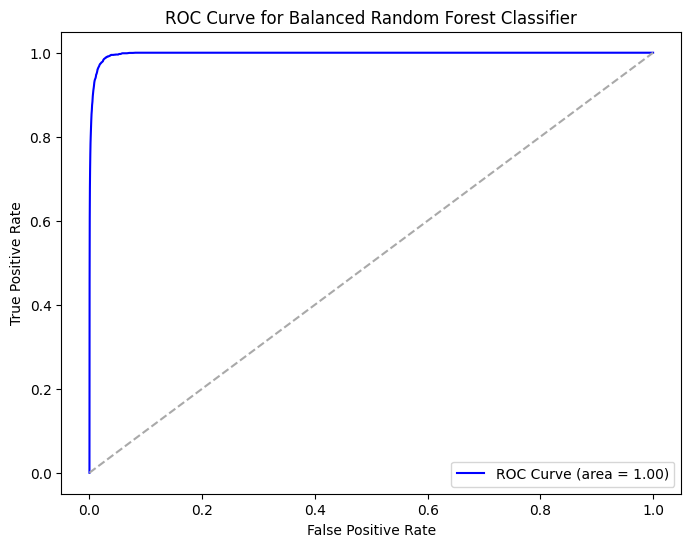

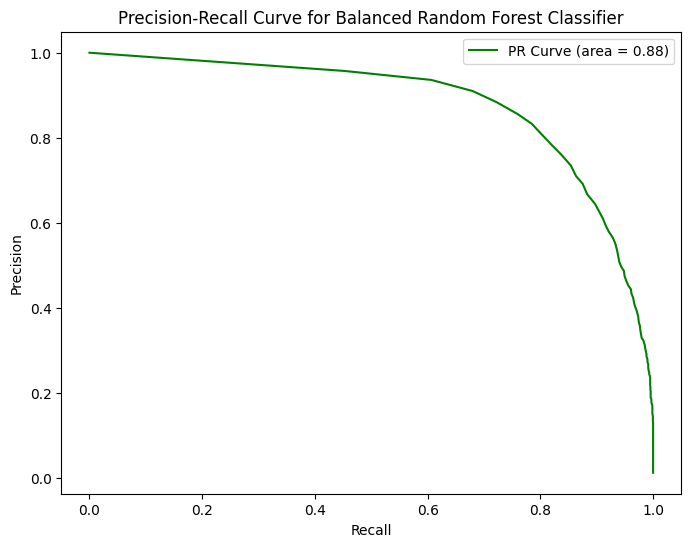

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Instantiate the BRF Classifier model
brf_classifier = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

evaluate_model(brf_classifier, "Balanced Random Forest Classifier", X_train, y_train, X_test, y_test)

#### XGB Boosting

Classification Report for XGBoost Classifier:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    193918
           1       0.91      0.81      0.86      2315

    accuracy                           1.00    196233
   macro avg       0.95      0.91      0.93    196233
weighted avg       1.00      1.00      1.00    196233



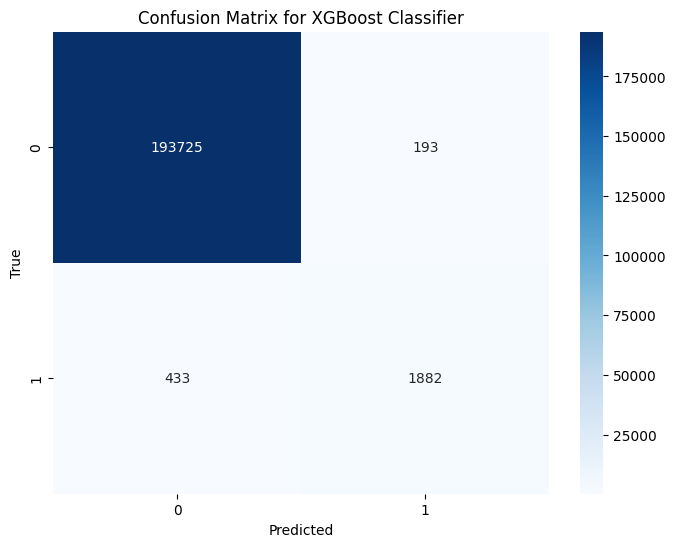

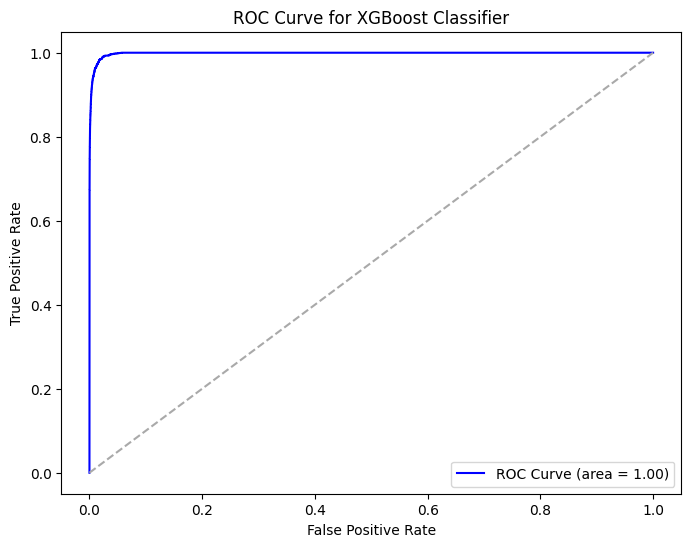

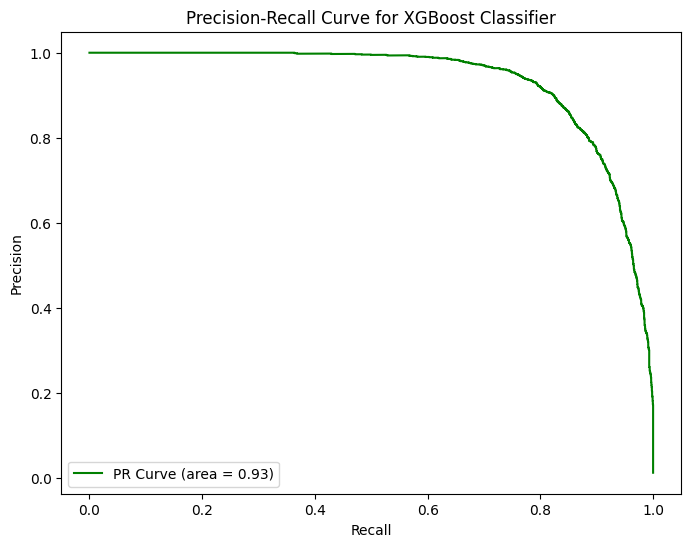

In [ ]:
from xgboost import XGBClassifier

# Instantiate the XGBClassifier model
xgb_classifier_model = XGBClassifier()

# Evaluate the model
evaluate_model(xgb_classifier_model, "XGBoost Classifier", X_train, y_train, X_test, y_test)

#### Ada Boost

Classification Report for AdaBoost:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    193918
           1       0.89      0.64      0.74      2315

    accuracy                           0.99    196233
   macro avg       0.94      0.82      0.87    196233
weighted avg       0.99      0.99      0.99    196233



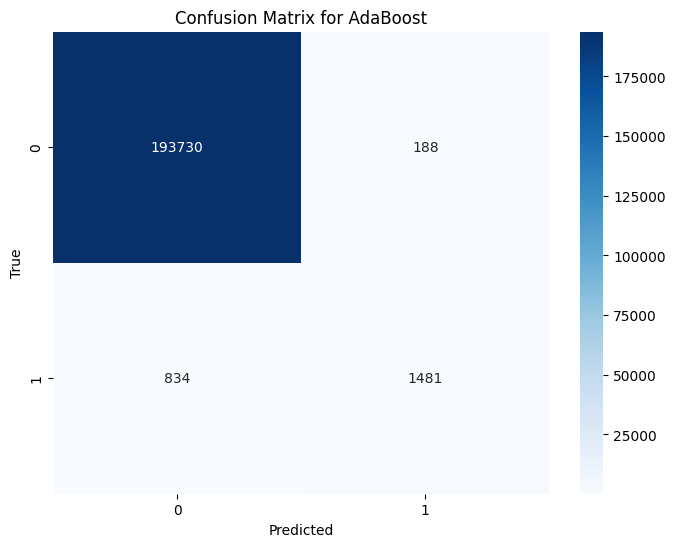

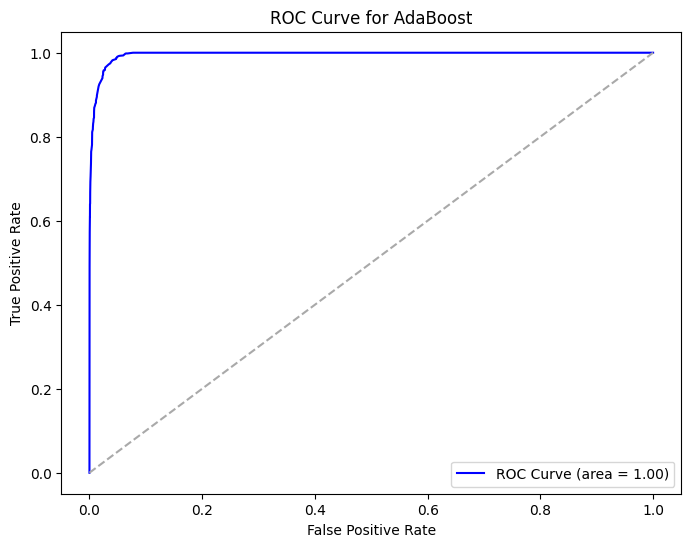

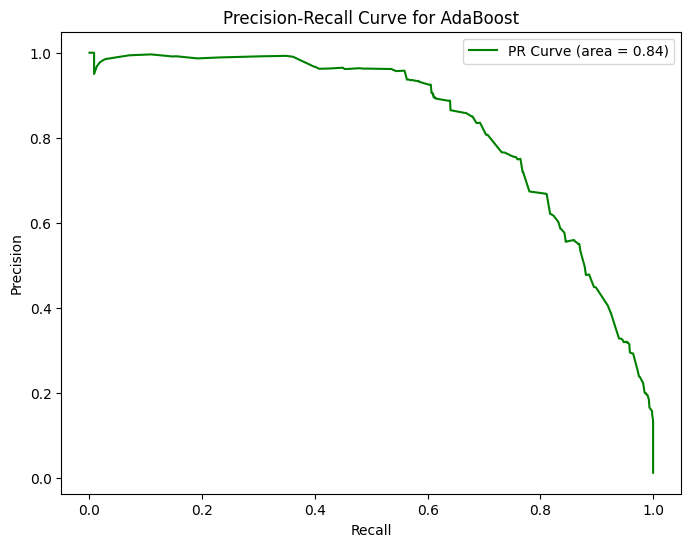

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Instantiate the LinearSVC model
ada = AdaBoostClassifier(random_state=42)

# Evaluate the model
evaluate_model(ada, "AdaBoost",  X_train, y_train, X_test, y_test)


Upon evaluating the models, both Random Forest and XGBoost demonstrated strong performance.

### Models with SMOTE

#### KNN Model

Classification Report for KNN Classifier:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    193918
           1       0.88      0.76      0.82      2315

    accuracy                           1.00    196233
   macro avg       0.94      0.88      0.91    196233
weighted avg       1.00      1.00      1.00    196233



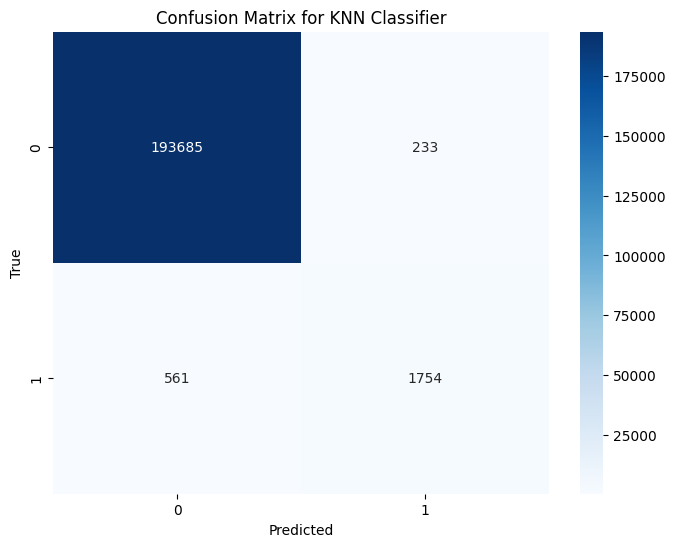

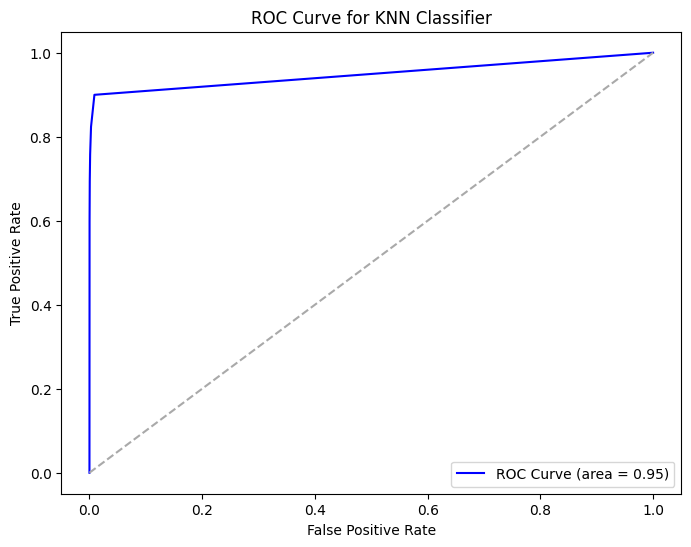

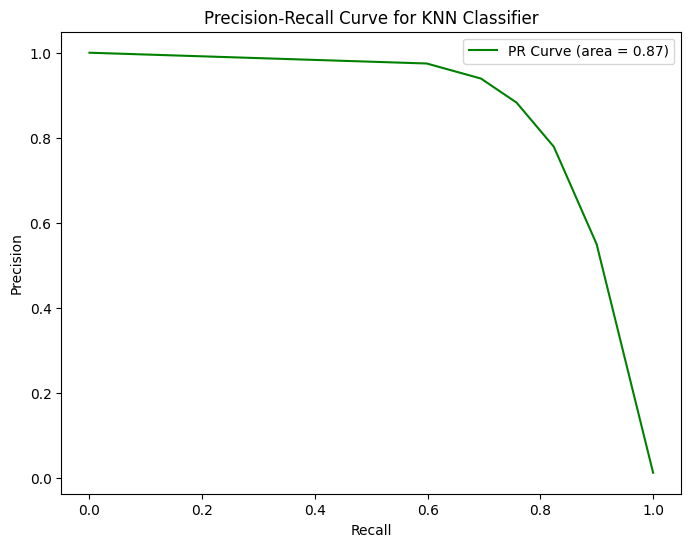

In [ ]:
# importing the KNN library
from sklearn.neighbors import KNeighborsClassifier

# Build and train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)
evaluate_model(knn, "KNN Classifier", X_train, y_train, X_test, y_test)

#### Logistic Regression

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    193918
           1       0.16      0.99      0.27      2315

    accuracy                           0.94    196233
   macro avg       0.58      0.96      0.62    196233
weighted avg       0.99      0.94      0.96    196233



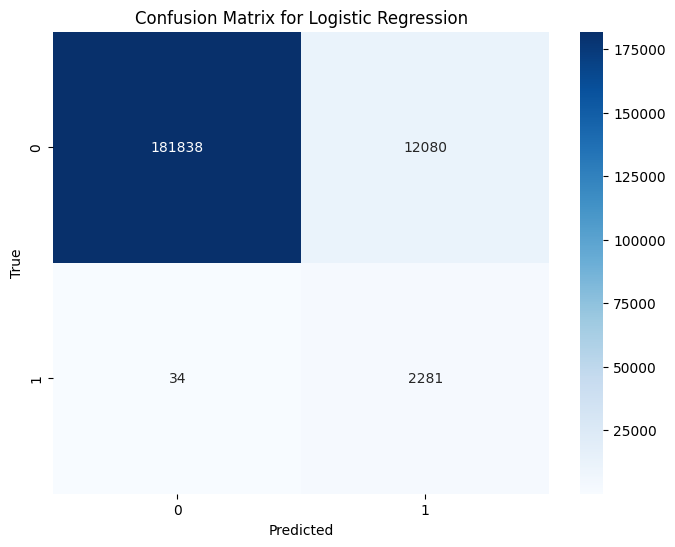

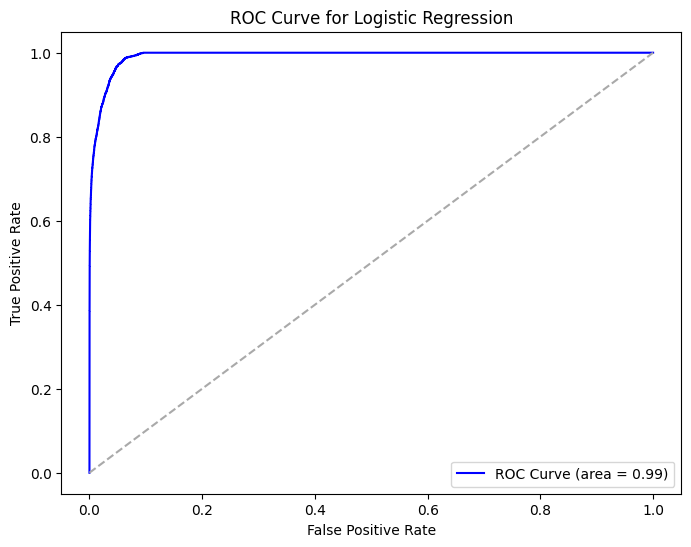

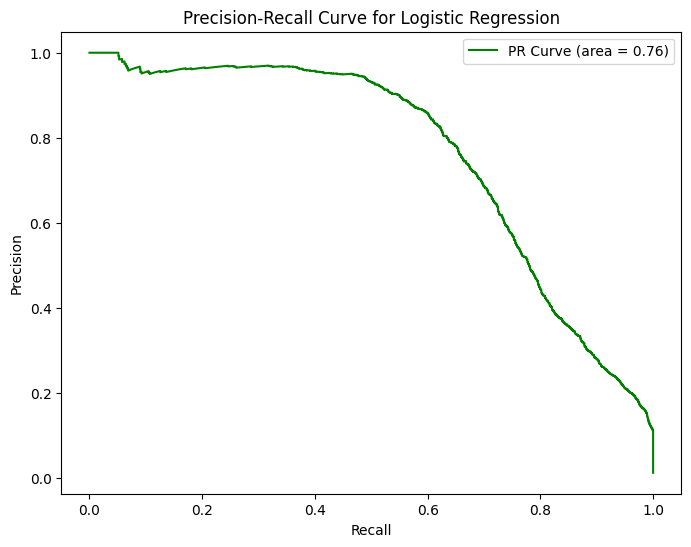

In [ ]:
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
logistic_regression_model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Evaluate the model
evaluate_model(logistic_regression_model, "Logistic Regression",  X_train, y_train, X_test, y_test)

After applying the models to the SMOTE-augmented data, their performance remained poor. Overall, SMOTE did not yield strong classification results in terms of precision, recall, or F1 score.

# Results
### Among all models, XGBoost and Random Forest delivered the most promising results for this classification task.
To optimize their performance, a GridSearch was conducted to find the best hyperparameters.

### Grid Search + XGBoost

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.8}
Classification Report for Best XGBoost:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    193918
           1       0.90      0.82      0.86      2315

    accuracy                           1.00    196233
   macro avg       0.95      0.91      0.93    196233
weighted avg       1.00      1.00      1.00    196233



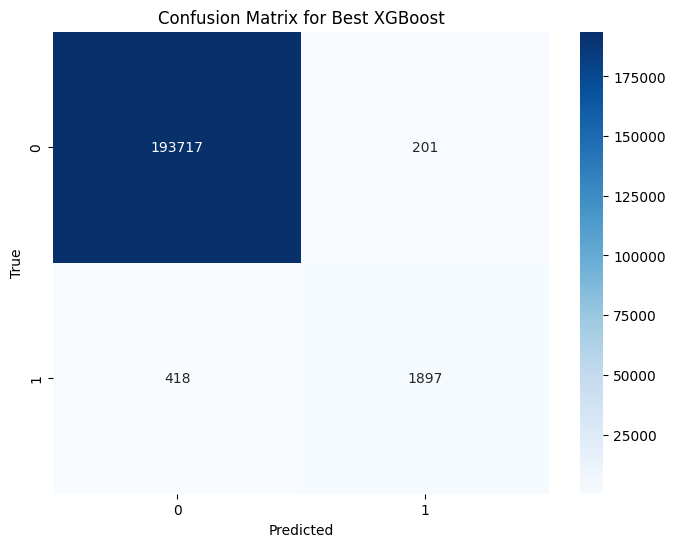

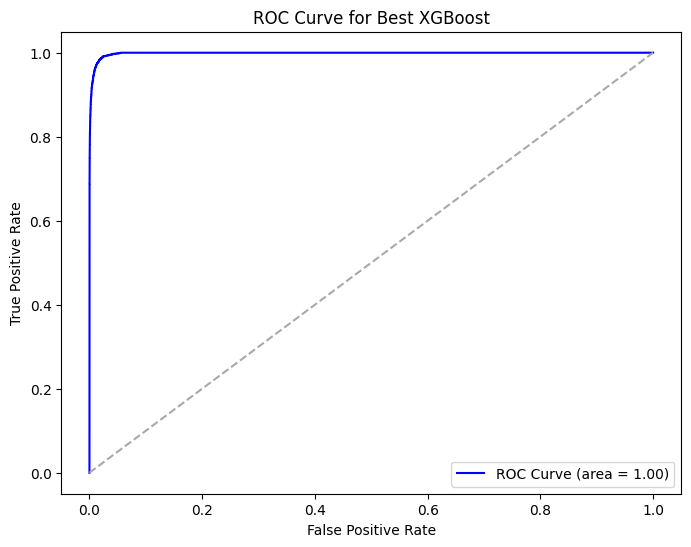

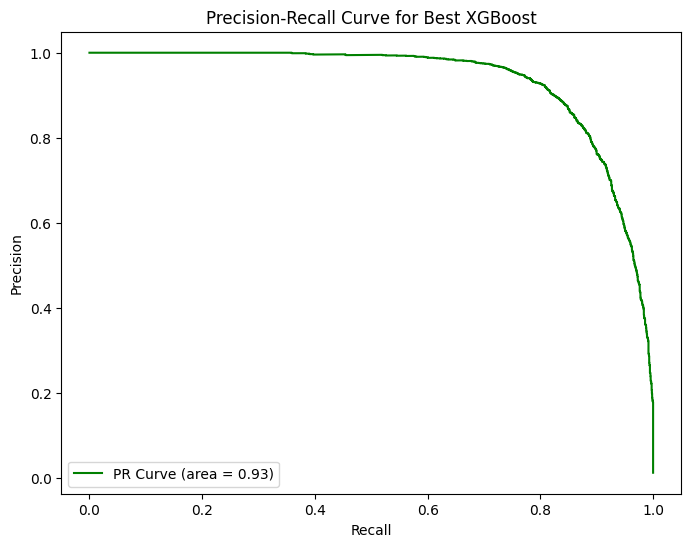

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Create a base model with the corrected objective parameter
xgb = XGBClassifier(random_state=42, objective='binary:logistic')

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           cv=cv, n_jobs=-1, verbose=1, scoring='recall')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the best model (optional)
best_model = grid_search.best_estimator_
evaluate_model(best_model, "Best XGBoost", X_train, y_train, X_test, y_test)

### Random Search + Random Forest

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best parameters found:  {'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 157}
Classification Report for Best RF (Fast Tune):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    193918
           1       0.93      0.77      0.84      2315

    accuracy                           1.00    196233
   macro avg       0.96      0.89      0.92    196233
weighted avg       1.00      1.00      1.00    196233



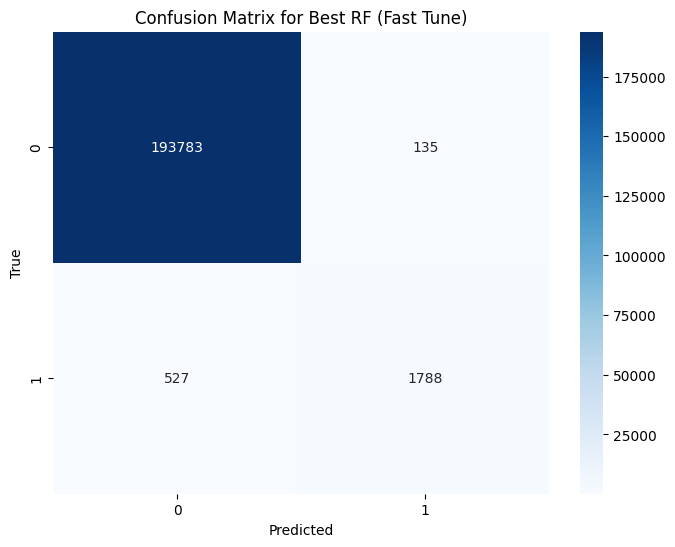

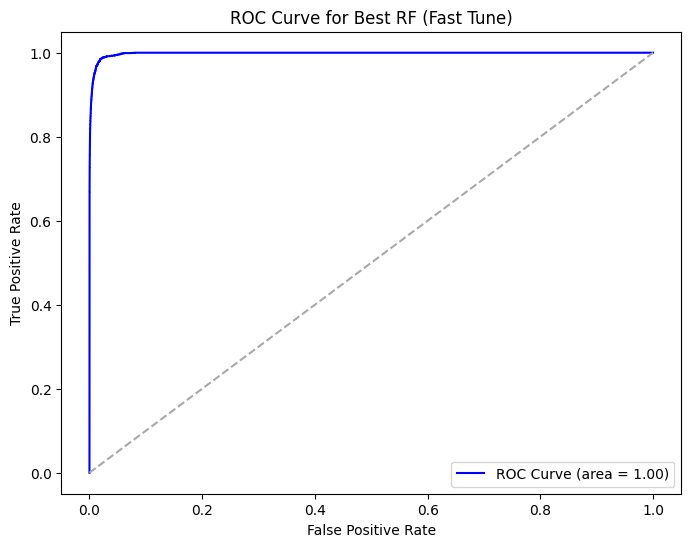

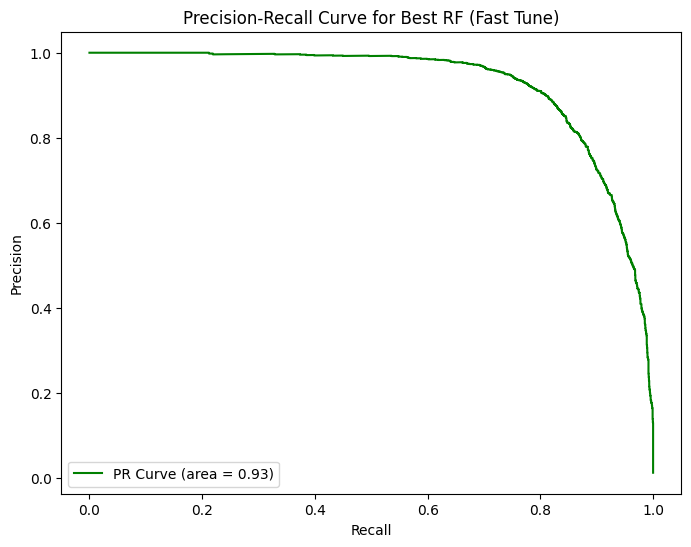

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint

# Create a base Random Forest model
rf = RandomForestClassifier(random_state=42)

# Tighter parameter distribution for faster search
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(10, 15),
    'min_samples_split': randint(10, 20),
    'min_samples_leaf': randint(1, 3)
}

# Reduced cross-validation splits
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Fewer iterations to reduce total runtime
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    scoring='recall'
)

# Run the search
random_search.fit(X_train, y_train)

# Output best params and evaluate
print("Best parameters found: ", random_search.best_params_)

best_model = random_search.best_estimator_
evaluate_model(best_model, "Best RF (Fast Tune)", X_train, y_train, X_test, y_test)


# Ensemble XGBoost + Random Forest

Classification Report for Ensemble XGBoost + RF:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    193918
           1       0.94      0.76      0.84      2315

    accuracy                           1.00    196233
   macro avg       0.97      0.88      0.92    196233
weighted avg       1.00      1.00      1.00    196233



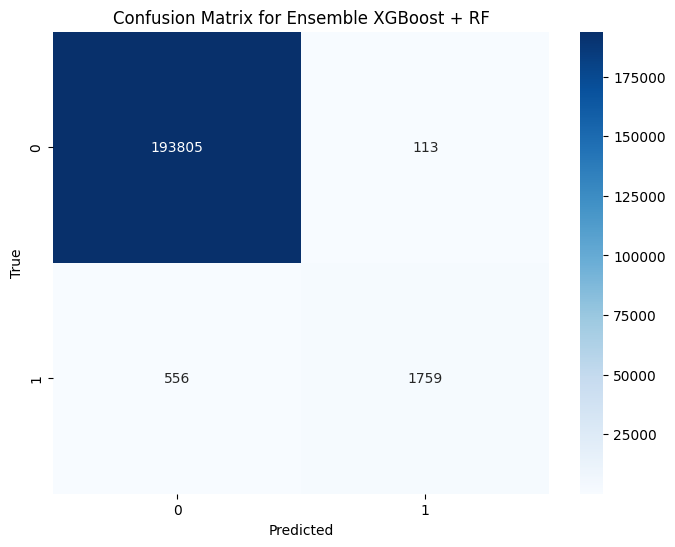

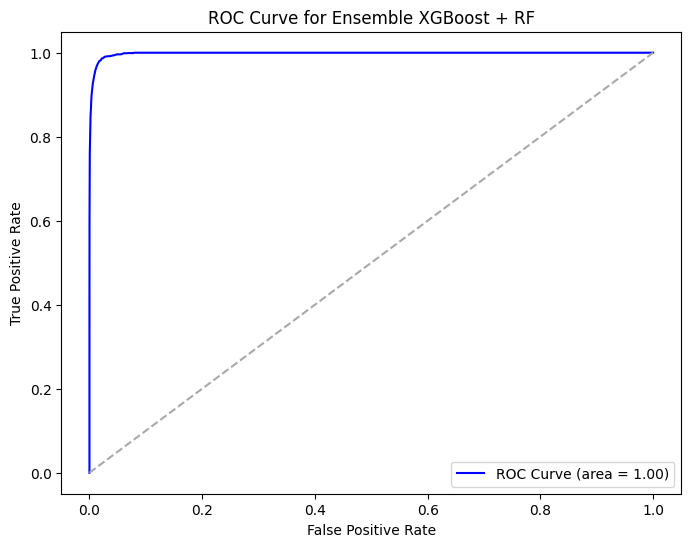

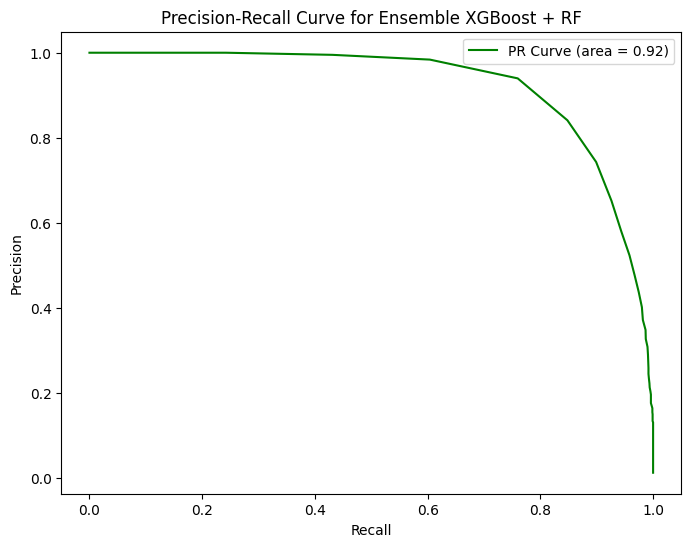

In [54]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Load the dataset
data = df.copy()

# Define the base model as Random Forest
base_model = RandomForestClassifier(random_state=42, max_depth= 14, min_samples_leaf = 1, min_samples_split= 16, n_estimators= 389)

# Define the meta-model as XGBoost
meta_model = XGBClassifier(use_label_encoder=False, eval_metric='aucpr', random_state=42,
                           objective='binary:logistic',learning_rate = 0.1, max_depth= 5, n_estimators = 400, subsample = 0.8)

# Create the stacking model
stacked_model = StackingClassifier(estimators=[('rf', base_model)], final_estimator=meta_model)

# Train the stacked model
stacked_model.fit(X_train, y_train)

# Predict and evaluate the model
evaluate_model(stacked_model, "Ensemble XGBoost + RF", X_train, y_train, X_test, y_test)

#Fraud Detection in Banking Transactions-
The project began with an exploratory data analysis (EDA) to uncover key insights from the dataset. The following findings emerged:

Severe Class Imbalance: Only 1.21% of transactions were labeled as fraudulent, indicating a highly imbalanced dataset. This necessitates using models that are either robust to class imbalance or employing techniques like synthetic oversampling (e.g., SMOTE).

Fraud Involves Larger Sums: While fraudulent transactions were fewer in number, they often involved significantly larger monetary amounts.

High-Risk Categories: Fraudulent activity was most prevalent in categories such as Sport & Toys, Health, and Wellness & Beauty.

Age and Gender Patterns: Customers in age categories 2 and 3 were more frequently involved in fraud, and interestingly, the data indicated that female customers were associated with more fraudulent transactions than males.

Due to the large number of features, dimensionality reduction was considered. However, since each principal component had an adequate level of explained variance, further reduction was not pursued.

📊 Evaluation Strategy
In fraud detection, both precision and recall are critical:

Recall measures how many actual fraudulent transactions were correctly identified.

Precision evaluates how many of the predicted frauds were truly fraudulent.

Balancing these two metrics is essential to avoid false positives that inconvenience customers and false negatives that let fraud slip through. Therefore, Precision-Recall AUC (PR-AUC) was used alongside other evaluation metrics.

✅ Best Performing Model
After tuning models using Grid Search, XGBoost emerged as the top performer. It achieved:

* High AUC score

* Balanced precision and recall

* Lowest Type II error (missed frauds)


While ensemble models had slightly lower false positives (Type I error), minimizing Type II error was prioritized — aligning with the real-world goal of reliably detecting fraudulent transactions in real-time.

